In [1]:
# # data_frame.distrito.value_counts()
# # pd.to_datetime(data_frame.fecha[-1])
# # pd.to_datetime('')
# print(pd.to_datetime(data_frame.fecha.iloc[-1], format='%d/%m/%Y'))
# print(pd.to_datetime(octubre_2022.FX_DATOS_INI.iloc[-1], format='%Y-%m-%d'))

In [2]:
# agosto_2021 = pd.read_csv('/home/luis/Descargas/Rango_Edades_Seccion_202108.csv',delimiter=';')
# # octubre_2022.DESC_DISTRITO.value_counts()
# type(agosto_2021.FX_DATOS_INI[0])
# agosto_2021.FX_DATOS_INI[0]

In [3]:
# import tensorflow as tf
# import tensorflow_datasets as tfds
# from tensorflow.keras.models import Sequential

# from keras_fsl.models.encoders import BasicCNN
# from keras_fsl.layers import GramMatrix
# from keras_fsl.losses.gram_matrix_losses import BinaryCrossentropy
# from keras_fsl.metrics.gram_matrix_metrics import classification_accuracy, min_eigenvalue
# from keras_fsl.utils.tensors import get_dummies

# #%% Get data
# train_dataset, val_dataset, test_dataset = [
#     dataset.shuffle(1024).batch(64).map(lambda x, y: (tf.image.convert_image_dtype(x, tf.float32), get_dummies(y)[0]))
#     for dataset in tfds.load(name="omniglot", split=["train[:90%]", "train[90%:]", "test"], as_supervised=True)
# ]

# input_shape = next(tfds.as_numpy(train_dataset.take(1)))[0].shape[1:]  # first shape is batch_size

# #%% Training
# encoder = BasicCNN(input_shape=input_shape)
# support_layer = GramMatrix(kernel="DenseSigmoid")
# model = Sequential([encoder, support_layer])
# model.compile(optimizer="Adam", loss=BinaryCrossentropy(), metrics=[classification_accuracy(), min_eigenvalue])
# model.fit(train_dataset, validation_data=val_dataset, epochs=5)

[TFM](https://github.com/jmrplens/TFG-TFM_EPS)

# Diagrama de flujo

<center><img width='600px' src="Data/Data_flow.png"/></center>

Metodología
https://ieeexplore.ieee.org/stamp/stamp.jsp?tp=&arnumber=294849

# Métodos

## Carga Google Drive

In [4]:
# from google.colab import drive
# drive.mount('/content/drive')

## Versión y especificación de directorios

In [5]:
from datetime import datetime

MODEL_TIMESTAMP = datetime.now().strftime("%Y-%m-%d-%H:%M:%S")


WEIGHTS_PATH  = './feature_weights/'
REPORTS_PATH  = 'Reports/'
MODELS_PATH   = 'Models/'
F1_SCORES_PATH = 'F1scores/'
GA_SCORES_PATH = 'GA_Scores/'
HYPERPARAMS_PATH = './hyperparams/'

HYPERPARAMS_EVOLUTON_PATH = './hyperparams_evolution/'
FINAL_POPULATION_PATH  = './population/'
CONFUSIONS_MATRIX_PATH = 'confusion_matrix/'
TSNE_PATH = 'tsne/'

REPORTS_TIMES_PATH = 'times/'


###### MODELS ######
MODELS_NAME = ['knn', 'convolution_1d', 'convolution_2d', 'nb', 'svc', 'auto_ml']

REPORTS_SUMMARY_PATH = f"{REPORTS_PATH}summary/"
######## CONFIG ########
loaded_timestamp = '2023-03-26-20:53:54'

In [6]:
laptop = False
calculate_weights = False
tsne = False

madrid = True

tree_method = 'auto' if laptop else 'gpu_hist'

train_nn = not laptop
other_models = cnn1d = False
cnn1d = True
cnn2d = True
other_models = cnn1d = True

# calculate_cnn_hyperparams = True
calculate_cnn_hyperparams = False

In [7]:
# laptop = True
# calculate_weights = True
# tsne = False

# leeds  = False
# madrid = False
# UK = True

# tree_method = 'auto' if laptop else 'gpu_hist'
# # tree_method = 'gpu_hist'
# train_nn = False
# other_models = cnn1d = False

## Importar Tensorflow

In [8]:
# !pip install tensorflow-addons

In [9]:
import tensorflow as tf
from tensorflow.keras import backend as K
from tensorflow.keras import layers, models
from tensorflow.keras.regularizers import l2
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import applications, optimizers
from tensorflow.keras.applications.vgg16 import VGG16, preprocess_input
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array
from tensorflow.keras.utils import model_to_dot, plot_model
from tensorflow.keras.layers import Input, Lambda, Activation, Conv2D, MaxPooling2D, BatchNormalization, Add, concatenate, Conv2DTranspose, Flatten

2023-04-23 11:40:58.991553: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-04-23 11:40:59.057965: I tensorflow/core/util/util.cc:169] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-04-23 11:40:59.075409: E tensorflow/stream_executor/cuda/cuda_blas.cc:2981] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2023-04-23 11:40:59.376376: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: li

In [10]:
# device_name = tf.test.gpu_device_name()
# if device_name != '/device:GPU:0':
#   raise SystemError('GPU device not found')
# print('Found GPU at: {}'.format(device_name))
# # !nvidia-smi

## Importador/Exportador JSON

In [11]:
import json

def write_json(feature_vector, root_path, file_name):
    with open(root_path + file_name, 'w') as outfile:
        json.dump(feature_vector, outfile)

def load_json(root_path, file_name):
    with open(root_path + file_name) as json_file:
        data = json.load(json_file)

    return data

## Construcción de imágenes

In [12]:
import numpy as np
import math
from matplotlib import pyplot as plt

def get_feature_matrix_indexes(sorted_feature_vector,matrix):  

    half_row = round((matrix.shape[0] - 1) / 2)
    half_column = round((matrix.shape[1] - 1) / 2)

    matrix_indexes = {}

    index = 0

    for parent_key in sorted_feature_vector:
        normalized_index = math.ceil(index/2)

        if (index % 2 != 0): # Impar
            current_row = half_row - normalized_index
        else: # Par
            current_row = half_row + normalized_index

        sorted_child_indexes = np.argsort(feature_vector[parent_key]['feature_weights'])[::-1]

        child_names   = np.array(feature_vector[parent_key]['feature_childs'])
        child_weights = np.array(feature_vector[parent_key]['feature_weights'])

        sorted_child_names   = child_names[sorted_child_indexes]
        sorted_child_weights = child_weights[sorted_child_indexes]

        position = 0
        for sorted_child_index in sorted_child_indexes:
            normalized_position = math.ceil(position/2)

            if (position % 2 != 0): # Impar
                current_column = half_column - normalized_position
            else: # Par
                current_column = half_column + normalized_position

            matrix_indexes[child_names[sorted_child_index]] = [current_row, current_column]
            position = position + 1 

        index = index + 1

    return matrix_indexes
    
def fv2gi(feature_vector):

    max_dimension = 0
    for key in feature_vector:
        childs_number = len(feature_vector[key]['feature_childs'])
        max_dimension = max(childs_number, max_dimension)
                
    matrix = np.zeros((max_dimension, max_dimension))

    weights_vector = []
    for parent_key in feature_vector:
        wpi = sum([float(child_weight) for child_weight in feature_vector[parent_key]['feature_weights']])
        feature_vector[parent_key]['wpi'] = wpi
        weights_vector.append(wpi)

   
    sorted_feature_vector = sorted(feature_vector.items(),
                                   key = lambda item: item[1]['wpi'],
                                   reverse = True)
     
    sorted_feature_vector = dict(sorted_feature_vector)

    
    matrix_indexes = get_feature_matrix_indexes(sorted_feature_vector, matrix)

    return matrix_indexes

# matrix_indexes = fv2gi(feature_vector)

## Construcción Feature Vector

In [13]:
def fill_feature_vector(X_dataset,child_weights):
  # Obtenemos el set de columnas del dataset
  train_columns_set  = set(X_dataset.columns)

  for parent_feature in feature_vector.keys():
    # Obtiene el set de características hijas del padre actual
    # dict.fromleys para mantener el orden, un set desordena los valores
    feature_childs_set = dict.fromkeys(feature_vector[parent_feature]['feature_childs'])

    # Obtener el índice de las columnas del actual padre para acceder a los pesos del XGBoost
    index_feature_childs = X_dataset.columns.get_indexer(feature_childs_set)

    feature_vector[parent_feature]['feature_weights'] = list([str(child_weight) for child_weight in child_weights[index_feature_childs]])

  return feature_vector

## Normalización de datos

In [14]:
from scipy.stats import zscore
import pandas as pd

def normalize_data(X_data):

    # Create a sample df
    normalized_df = X_data

    # Calculate the zscores and drop zscores into new column
    for column in normalized_df.columns:
        normalized_df[column] = zscore(normalized_df[column])
    
    return normalized_df

## Oversampling de datos

In [15]:
from imblearn.over_sampling import BorderlineSMOTE
from imblearn.over_sampling import RandomOverSampler
from imblearn.over_sampling import KMeansSMOTE

def oversample_data(X_data, Y_labels):

    oversampler = BorderlineSMOTE(kind='borderline-2', random_state = 3)
    # oversampler = RandomOverSampler()
    # oversampler = KMeansSMOTE()
    X_oversampled, Y_oversampled = oversampler.fit_resample(X_data, Y_labels)

    print('********** After OverSampling **********')
    # print('Slight: ', (Y_oversampled == 'Slight').sum())
    # print('Serious:', (Y_oversampled == 'Serious').sum())
    # print('Fatal:  ', (Y_oversampled == 'Fatal').sum())
    # print('\n Total X: ', len(X_oversampled), ' Total Y: ', len(Y_oversampled), '\n')

    # print('********** After OverSampling **********')
    print('Slight: ', (Y_oversampled == 'Slight').sum())
    print('Assistance:', (Y_oversampled == 'Assistance').sum())
    print('\n Total X: ', len(X_oversampled), ' Total Y: ', len(Y_oversampled), '\n')

    return X_oversampled, Y_oversampled

## Construcción de imágenes

In [16]:
def build_gray_images(dataset, max_dimension, matrix_indexes):

    matrix_3d = np.zeros((max_dimension, max_dimension, len(dataset.index)))
    print(len(dataset.index))
    for feature, value in matrix_indexes.items():
        matrix_3d[value[0], value[1],] = dataset[feature]
        
    return matrix_3d

## Algoritmo genético

In [17]:
HYPERPARAMS_TO_OPTIMIZE = {'eta': {'type': 'float',
                                   'init': [0.01, 1],
                                   'mutation': [-0.2, 0.2],
                                   'round': 2
                                   },
                           'max_depth': {'type': 'int',
                                         'init': [1, 25],
                                         'mutation': [-3, 3],
                                         'step': 1
                                   },
                           'min_child_weight': {'type': 'float',
                                                'init': [0.01, 20.0],
                                                'mutation': [-4, 4],
                                                'round': 1
                                   }
                          }

number_of_individuals = 50
numberOfParentsMating = 10
number_of_hyperparams = len(HYPERPARAMS_TO_OPTIMIZE)
number_of_generations = 50

### Inicializar población

In [18]:
from src.genetic_algorithm import generate_individual
from src.genetic_algorithm import initialize_population

### Fitness function

In [19]:
from src.genetic_algorithm import fitness_f1score

### Evaluación de población

In [20]:
def train_population(population, hyperparams_to_optimize, dMatrixTrain, dMatrixTest, Y_test):

    fScore = []
    
    params = {'objective':'multi:softprob',
              'tree_method': 'auto',
              'single_precision_histogram': True,
              'num_class': 2
             }

    # params = {'objective':'binary:logistic',
    #           'tree_method': tree_method,
    #           'single_precision_histogram': True
    #          }
    for individual_index in range(population.shape[0]):
        # Se almacenan en hyperparams_to_optimize los valores del individuo con su nombre correspondiente de hyperparams_name_to_optimize.
        hyperparams = {}

        for index, hyperparam_value in enumerate(population[individual_index]):

            hyperparam_name_to_optimize = list(hyperparams_to_optimize.keys())[index]
            data_type = hyperparams_to_optimize[hyperparam_name_to_optimize]['type']

            hyperparams[hyperparam_name_to_optimize] = hyperparam_value
            hyperparams[hyperparam_name_to_optimize] = hyperparams[hyperparam_name_to_optimize].astype(data_type)
        
        params.update(hyperparams)

        # num_round = params['n_estimators']
        
        start = time.time()

        xgb.set_config(verbosity = 0)
        bst = xgb.train(params,
                        dMatrixTrain)

        end = time.time()

        preds = bst.predict(dMatrixTest)
        
        single_predictions = [np.argmax(pred) for pred in preds]
        # preds = preds > 0.5
        fitness_score = fitness_f1score(Y_test, single_predictions)

        # print(f"{individual_index}: {hyperparams} --> time(s): {round(end - start, 2)} --> score: {fitness_score}")

        fScore.append(fitness_score)

    return fScore

### Selección de padres

In [21]:
# Select parents for mating
def new_parents_selection(population, fitness, numParents):
    selectedParents = np.empty((numParents, population.shape[1])) # Create an array to store fittest parents.

    for parentId in range(numParents):
        bestFitnessId = np.where(fitness == np.max(fitness))
        bestFitnessId  = bestFitnessId[0][0]
        selectedParents[parentId, :] = population[bestFitnessId, :]
        fitness[bestFitnessId] = -1 # Set this value to negative, in case of F1-score, so this parent is not selected again

    return selectedParents

### Cruzamiento de población

In [22]:
'''
Mate these parents to create children having parameters from these parents (we are using uniform crossover method)
'''
def crossover_uniform(parents, childrenSize):
    
    crossoverPointIndex  = np.arange(0, np.uint8(childrenSize[1]), 1, dtype= np.uint8) # get all the index
    crossoverPointIndex1 = np.random.randint(0, np.uint8(childrenSize[1]), np.uint8(childrenSize[1]/2)) # select half  of the indexes randomly
    crossoverPointIndex2 = np.array(list(set(crossoverPointIndex) - set(crossoverPointIndex1))) #select leftover indexes
    
    children = np.empty(childrenSize)
    
    '''
    Create child by choosing parameters from two parents selected using new_parent_selection function. The parameter values
    will be picked from the indexes, which were randomly selected above. 
    '''
    for i in range(childrenSize[0]):
        
        #find parent 1 index 
        parent1_index = i%parents.shape[0]
        #find parent 2 index
        parent2_index = (i+1)%parents.shape[0]
        #insert parameters based on random selected indexes in parent 1
        children[i, crossoverPointIndex1] = parents[parent1_index, crossoverPointIndex1]
        #insert parameters based on random selected indexes in parent 1
        children[i, crossoverPointIndex2] = parents[parent2_index, crossoverPointIndex2]

    return children

### Mutación

In [23]:
def mutation(crossover, hyperparams_to_optimize):
    
    # MUTATION_PROBABILITY = 1/numberOfParameters
    
    MUTATION_PROBABILITY = 0.4
    number_of_parameters = len(hyperparams_to_optimize)

    for idx in range(crossover.shape[0]):

        mutation_probability = np.random.rand(1)

        while MUTATION_PROBABILITY > mutation_probability:

            mutationValue = 0

            hyperparam_selected_index = np.random.randint(0, number_of_parameters)
            hyperparam_selected_name  = list(hyperparams_to_optimize.keys())[hyperparam_selected_index]

            min_limit_value = hyperparams_to_optimize[hyperparam_selected_name]['init'][0]
            max_limit_value = hyperparams_to_optimize[hyperparam_selected_name]['init'][1]

            min_mutation_value = hyperparams_to_optimize[hyperparam_selected_name]['mutation'][0]
            max_mutation_value = hyperparams_to_optimize[hyperparam_selected_name]['mutation'][1]

            data_type = hyperparams_to_optimize[hyperparam_selected_name]['type']
            
            if data_type == 'int':
                step = hyperparams_to_optimize[hyperparam_selected_name]['step']
                mutationValue = int(random.randrange(min_mutation_value, max_mutation_value, step = step))

            if data_type == 'float':
                round_to = hyperparams_to_optimize[hyperparam_selected_name]['round']
                mutationValue = round(random.uniform(min_mutation_value, max_mutation_value), round_to)
                
            # print(idx, hyperparam_selected_name, mutationValue)

            crossover[idx, hyperparam_selected_index] = crossover[idx,hyperparam_selected_index] + mutationValue

            if(crossover[idx, hyperparam_selected_index] > max_limit_value):
                crossover[idx, hyperparam_selected_index] = max_limit_value

            if(crossover[idx, hyperparam_selected_index] < min_limit_value):
                crossover[idx, hyperparam_selected_index] = min_limit_value
                
            mutation_probability = np.random.rand(1)


    return crossover

## Reshape de imágenes

In [24]:
# Add one channel
# https://machinelearningmastery.com/a-gentle-introduction-to-channels-first-and-channels-last-image-formats-for-deep-learning/

# Add one channel to gray images depending of the number of the data
def shape_images(X_data, gray_images):
  images = []

  for i in range(0,len(X_data)):
      original_matrix = gray_images[:,:,i]
      # print(original_matrix.shape)
      shaped_image = np.expand_dims(original_matrix, axis=2)
      # print(shaped_image.shape)
      images.append(shaped_image)
      # plt.matshow(shaped_image)

  return images

## One-Hot Encoder/Decoder

In [25]:
def casualty_to_one_hot(Y_labels):

    transf = {
        'Slight': 0,
        'Serious': 1,
        'Fatal': 2
    }

    Y_labels.replace(transf, inplace = True)

    return tf.one_hot(Y_labels, 3)

def one_hot_to_casualty(Y_labels):

    transf = {
        0: 'Slight',
        1: 'Serious',
        2: 'Fatal'
    }   

    return Y_labels.replace(transf)

In [26]:
def casualty_to_one_hot(Y_labels):

    transf = {
        'Slight': 0,
        'Assistance': 1
    }

    Y_labels.replace(transf, inplace = True)

    return tf.one_hot(Y_labels, 2)

def one_hot_to_casualty(Y_labels):

    transf = {
        0: 'Slight',
        1: 'Assistance'
    }   

    return Y_labels.replace(transf)

## Visualización de datos

### Matriz de correlación

In [27]:
import seaborn as sns

def correlation_matrix(X_data):
    corrMatrix = X_data.corr()
    fig,ax  = plt.subplots(1,1,figsize=(20,15))
    sns.heatmap(corrMatrix, annot=True)
    ax.set_xticklabels(ax.get_xticklabels(),rotation = 30)
    plt.savefig('saving-a-seaborn-plot-as-eps-file.svg')
    plt.show()


### PCA

In [28]:
from sklearn.decomposition import PCA

def pca(X_train_data, X_test_data):
    pca = PCA()
    X_train_pca = pca.fit_transform(X_train_data)
    X_test_pca  = pca.transform(X_test_data)
    explained_variance = pca.explained_variance_ratio_

    figure_name = plt.figure(figsize=(20, 15))
    plt.plot(np.cumsum(pca.explained_variance_ratio_))
    plt.xlabel('number of components')
    plt.ylabel('cumulative explained variance')
    plt.savefig('saving-a-seaborn-plot-as-eps-file.svg')
    plt.show()

### TSNE

In [29]:
from sklearn.manifold import TSNE
from sklearn.preprocessing import StandardScaler

def plot_TSNE(X_data, Y_data, n_components, output_file_name, title):

    # X_data_scaled = StandardScaler().fit_transform(X_data)
    z_data = TSNE(n_components = n_components).fit_transform(X_data)

    # X_test_scaled = StandardScaler().fit_transform(X_test),
    # z_test = TSNE(n_components=2).fit_transform(X_test_scaled),

    palette = sns.color_palette('husl', 3)
    fig,ax  = plt.subplots(1, 1, figsize=(7,4))
    sns.scatterplot(x = z_data[:,0],
                    y = z_data[:,1],
                    hue = Y_data,
                    palette = palette,
                    legend = 'full'
                   ).set(title = title)
    plt.xlabel('Dimension 1', weight = 'bold').set_fontsize('10')
    plt.ylabel('Dimension 1', weight = 'bold').set_fontsize('10')

    if (output_file_name): plt.savefig(output_file_name)

### Autoencoder

In [30]:
def autoencoder ():
    input_img = Input(shape=(25,))

    # definimos el encoder, que tendra una entrada de Input_img y una segunda capa con entrada de encoder1 y salida 3
    encoder1 = layers.Dense(15, activation='sigmoid')(input_img)
    encoder2 = layers.Dense(3, activation='sigmoid')(encoder1)

    # definimos el  decoder que tendra una entrada inicial de encoder3 y una salida de 128 y finalmete una capa de salida con los mismos que Input_img
    decoder1 = layers.Dense(15, activation='sigmoid')(encoder2)
    decoder2 = layers.Dense(25, activation='sigmoid')(decoder1)

    # this model maps an input to its reconstruction
    autoencoder = tf.keras.Model(inputs=input_img, outputs=decoder2)
    autoencoder.summary()

    autoencoder.compile(optimizer='adam',
                        loss='categorical_crossentropy',
                        metrics=[tfa.metrics.F1Score(num_classes = num_classes, average='micro', threshold=0.1)],) #se usan estos dos en estas arquitecturas
    
    return autoencoder

## C-GAN

In [31]:
from tensorflow import keras

class ConditionalGAN(keras.Model):
    def __init__(self, discriminator, generator, latent_dim):
        super(ConditionalGAN, self).__init__()
        self.discriminator = discriminator
        self.generator = generator
        self.latent_dim = latent_dim
        self.gen_loss_tracker = keras.metrics.Mean(name="generator_loss")
        self.disc_loss_tracker = keras.metrics.Mean(name="discriminator_loss")

    @property
    def metrics(self):
        return [self.gen_loss_tracker, self.disc_loss_tracker]

    def compile(self, d_optimizer, g_optimizer, loss_fn):
        super(ConditionalGAN, self).compile()
        self.d_optimizer = d_optimizer
        self.g_optimizer = g_optimizer
        self.loss_fn = loss_fn

    def train_step(self, data):
        # Unpack the data.
        real_images, one_hot_labels = data

        # Add dummy dimensions to the labels so that they can be concatenated with
        # the images. This is for the discriminator.
        image_one_hot_labels = one_hot_labels[:, :, None, None] # TASPCNN: shape=(None, 2, 1, 1)
        image_one_hot_labels = tf.repeat(
            image_one_hot_labels, repeats=[image_size * image_size]
        ) # TASPCNN: shape=(None,)
        image_one_hot_labels = tf.reshape(
            image_one_hot_labels, (-1, image_size, image_size, num_classes)
        ) # TASPCNN: shape=(None, 25, 25, 2)

        # Sample random points in the latent space and concatenate the labels.
        # This is for the generator.
        batch_size = tf.shape(real_images)[0]
        random_latent_vectors = tf.random.normal(shape=(batch_size, self.latent_dim))
        random_vector_labels = tf.concat(
            [random_latent_vectors, one_hot_labels], axis=1
        ) # TASPCNN: shape=(None, 64)

        # Decode the noise (guided by labels) to fake images.
        #print(f"Random vector labels shape: {random_vector_labels.shape}")
        generated_images = self.generator(random_vector_labels) # TASPCNN: shape=(None, 20, 20, 1)
        #print(f"Generated images shape: {generated_images.shape}")

        # Combine them with real images. Note that we are concatenating the labels
        # with these images here.
        fake_image_and_labels = tf.concat([generated_images, image_one_hot_labels], -1)
        real_image_and_labels = tf.concat([real_images, image_one_hot_labels], -1)
        combined_images = tf.concat(
            [fake_image_and_labels, real_image_and_labels], axis=0
        )

        # Assemble labels discriminating real from fake images.
        labels = tf.concat(
            [tf.ones((batch_size, 1)), tf.zeros((batch_size, 1))], axis=0
        )

        # Train the discriminator.
        with tf.GradientTape() as tape:
            predictions = self.discriminator(combined_images)
            d_loss = self.loss_fn(labels, predictions)
        grads = tape.gradient(d_loss, self.discriminator.trainable_weights)
        self.d_optimizer.apply_gradients(
            zip(grads, self.discriminator.trainable_weights)
        )

        # Sample random points in the latent space.
        random_latent_vectors = tf.random.normal(shape=(batch_size, self.latent_dim))
        random_vector_labels = tf.concat(
            [random_latent_vectors, one_hot_labels], axis=1
        )

        # Assemble labels that say "all real images".
        misleading_labels = tf.zeros((batch_size, 1))

        # Train the generator (note that we should *not* update the weights
        # of the discriminator)!
        with tf.GradientTape() as tape:
            fake_images = self.generator(random_vector_labels)
            fake_image_and_labels = tf.concat([fake_images, image_one_hot_labels], -1)
            predictions = self.discriminator(fake_image_and_labels)
            g_loss = self.loss_fn(misleading_labels, predictions)
        grads = tape.gradient(g_loss, self.generator.trainable_weights)
        self.g_optimizer.apply_gradients(zip(grads, self.generator.trainable_weights))

        # Monitor loss.
        self.gen_loss_tracker.update_state(g_loss)
        self.disc_loss_tracker.update_state(d_loss)
        return {
            "g_loss": self.gen_loss_tracker.result(),
            "d_loss": self.disc_loss_tracker.result(),
        }


## 1D-Convolution

In [32]:


# import tensorflow_addons as tfa

# lr_init = 0.1

# convolution_1d = models.Sequential()
# convolution_1d.add(layers.Conv1D(256, 3, strides = 1, activation='relu', padding='same', input_shape=(5, 5, 1)))
# convolution_1d.add(layers.BatchNormalization())
# convolution_1d.add(layers.Conv1D(256, 3, strides = 1, activation='relu', padding='same'))
# convolution_1d.add(layers.BatchNormalization())
# convolution_1d.add(layers.Conv1D(256, 3, strides = 1, activation='relu', padding='same'))
# convolution_1d.add(layers.BatchNormalization())
# convolution_1d.add(layers.Conv1D(256, 3, strides = 1, activation='relu', padding='same'))
# convolution_1d.add(layers.Flatten())
# convolution_1d.add(layers.BatchNormalization())
# convolution_1d.add(layers.Dense(units=128))
# convolution_1d.add(layers.BatchNormalization())
# convolution_1d.add(layers.Dense(num_classes, activation='softmax'))

# convolution_1d.compile(
#     optimizer=Adam(learning_rate = lr_init, epsilon=1e-06),
#     loss='categorical_crossentropy',
#     metrics=[tfa.metrics.F1Score(num_classes = num_classes, average='micro', threshold=0.1)]
#   )



### 3 Classes

In [33]:
import tensorflow_addons as tfa

def get_1d_conv(fm_one, fm_two, fm_three, fm_four, dense, num_classes=2, dropout=0.2, learnRate=0.01):
    cnn_1d_conv = models.Sequential()
    cnn_1d_conv.add(layers.Conv1D(fm_one, 3, strides=1, activation='relu', padding='same', input_shape=(5, 5, 1)))
    cnn_1d_conv.add(layers.BatchNormalization())
    cnn_1d_conv.add(layers.Conv1D(fm_two, 3, strides=1, activation='relu', padding='same'))
    cnn_1d_conv.add(layers.BatchNormalization())
    cnn_1d_conv.add(layers.Conv1D(fm_three, 3, strides=1, activation='relu', padding='same'))
    cnn_1d_conv.add(layers.BatchNormalization())
    cnn_1d_conv.add(layers.Conv1D(fm_four, 3, strides=1, activation='relu', padding='same'))
    cnn_1d_conv.add(layers.Flatten())
    cnn_1d_conv.add(layers.BatchNormalization())
    cnn_1d_conv.add(layers.Dense(units=dense))
    cnn_1d_conv.add(layers.BatchNormalization())
    cnn_1d_conv.add(layers.Dense(3, activation='softmax'))

    cnn_1d_conv.compile(
        optimizer=Adam(learning_rate = learnRate, epsilon=1e-06),
        loss='categorical_crossentropy',
        metrics=[tfa.metrics.F1Score(num_classes = num_classes, average='micro', threshold=0.1)]
    )
    
    return cnn_1d_conv

# convolution_1d.compile(
#     optimizer=Adam(learning_rate = lr_init, epsilon=1e-06),
#     loss='categorical_crossentropy',
#     metrics=[tfa.metrics.F1Score(num_classes = num_classes, average='micro', threshold=0.1)]
#   )

### 2 Classes

In [34]:
import tensorflow_addons as tfa

def get_1d_conv(fm_one, fm_two, fm_three, fm_four, dense,  num_classes=2, dropout=0.2, learnRate=0.01):
    cnn_1d_conv = models.Sequential()
    cnn_1d_conv.add(layers.Conv1D(fm_one, 3, strides=1, activation='relu', padding='same', input_shape=(5, 5, 1)))
    cnn_1d_conv.add(layers.BatchNormalization())
    cnn_1d_conv.add(layers.Conv1D(fm_two, 3, strides=1, activation='relu', padding='same'))
    cnn_1d_conv.add(layers.BatchNormalization())
    cnn_1d_conv.add(layers.Conv1D(fm_three, 3, strides=1, activation='relu', padding='same'))
    cnn_1d_conv.add(layers.BatchNormalization())
    cnn_1d_conv.add(layers.Conv1D(fm_four, 3, strides=1, activation='relu', padding='same'))
    cnn_1d_conv.add(layers.Flatten())
    cnn_1d_conv.add(layers.BatchNormalization())
    cnn_1d_conv.add(layers.Dense(units=dense))
    cnn_1d_conv.add(layers.BatchNormalization())
    cnn_1d_conv.add(layers.Dense(3, activation='softmax'))

    cnn_1d_conv.compile(
        optimizer=Adam(learning_rate = learnRate, epsilon=1e-06),
        loss='binary_crossentropy',
        metrics=[tfa.metrics.F1Score(num_classes = num_classes, average='micro', threshold=0.1)]
    )
    
    return cnn_1d_conv

# convolution_1d.compile(
#     optimizer=Adam(learning_rate = lr_init, epsilon=1e-06),
#     loss='categorical_crossentropy',
#     metrics=[tfa.metrics.F1Score(num_classes = num_classes, average='micro', threshold=0.1)]
#   )

## TASP-CNN

In [35]:
# lr_init = 0.0001

# tasp_cnn = models.Sequential()
# tasp_cnn.add(layers.Conv2D(128, (3, 3), strides=(1, 1), activation='relu', padding='same', input_shape=(5, 5, 1)))
# tasp_cnn.add(layers.Dropout(.2,  input_shape=(3, 3, 128)))
# tasp_cnn.add(layers.BatchNormalization())
# tasp_cnn.add(layers.Conv2D(1024, (3, 3), strides=(1, 1), activation='relu', padding='same', input_shape=(3, 3, 128)))
# tasp_cnn.add(layers.Dropout(.2,  input_shape=(3, 3, 128)))
# tasp_cnn.add(layers.BatchNormalization())
# tasp_cnn.add(layers.Conv2D(512, (3, 3), strides=(1, 1), activation='relu', padding='same', input_shape=(3, 3, 1024)))
# tasp_cnn.add(layers.Dropout(.2,  input_shape=(3, 3, 32)))
# tasp_cnn.add(layers.BatchNormalization())
# tasp_cnn.add(layers.Conv2D(1024, (3, 3), strides=(1, 1), activation='relu', padding='same', input_shape=(3, 3, 512)))
# tasp_cnn.add(layers.Dropout(.2,  input_shape=(3, 3, 1024)))
# tasp_cnn.add(layers.Flatten())
# tasp_cnn.add(layers.BatchNormalization())
# tasp_cnn.add(layers.Dense(units=32))
# tasp_cnn.add(layers.Dropout(.5))
# tasp_cnn.add(layers.BatchNormalization())
# tasp_cnn.add(layers.Dense(num_classes, activation='softmax'))

# tasp_cnn.compile(
#     optimizer=Adam(learning_rate = lr_init, epsilon=1e-06),
#     loss='categorical_crossentropy',
#     metrics=[tfa.metrics.F1Score(num_classes = num_classes, average='micro', threshold=0.1)]
#   )

### 3 Classes

In [36]:
# def get_tasp_cnn(fm_one, fm_two, fm_three, fm_four, fm_five, fm_six, dense, dropout=0.2, learnRate=0.01):
def get_tasp_cnn(fm_one, fm_two, fm_three, fm_four, dense,  num_classes=2, dropout=0.2, learnRate=0.01):
    tasp_cnn = models.Sequential()
    tasp_cnn.add(layers.Conv2D(fm_one, (3, 3), strides=(1, 1), activation='relu', padding='same', input_shape=(5, 5, 1)))
    tasp_cnn.add(layers.BatchNormalization())
    tasp_cnn.add(layers.Conv2D(fm_two, (3, 3), strides=(1, 1), activation='relu', padding='same', input_shape=(3, 3, fm_one)))
    tasp_cnn.add(layers.BatchNormalization())
    tasp_cnn.add(layers.Conv2D(fm_three, (3, 3), strides=(1, 1), activation='relu', padding='same', input_shape=(3, 3, fm_two)))
    tasp_cnn.add(layers.BatchNormalization())
    tasp_cnn.add(layers.Conv2D(fm_four, (3, 3), strides=(1, 1), activation='relu', padding='same', input_shape=(3, 3, fm_three)))
    tasp_cnn.add(layers.Flatten())
    tasp_cnn.add(layers.BatchNormalization())
    tasp_cnn.add(layers.Dense(units=dense))
    tasp_cnn.add(layers.BatchNormalization())
    tasp_cnn.add(layers.Dense(num_classes, activation='softmax'))

    tasp_cnn.compile(
        optimizer=Adam(learning_rate = learnRate, epsilon=1e-06),
        loss='categorical_crossentropy',
        metrics=[tfa.metrics.F1Score(num_classes = num_classes, average='micro', threshold=0.1)]
      )
    
    return tasp_cnn

### 2 Classes

In [37]:
# def get_tasp_cnn(fm_one, fm_two, fm_three, fm_four, fm_five, fm_six, dense, dropout=0.2, learnRate=0.01):
def get_tasp_cnn(fm_one, fm_two, fm_three, fm_four, dense,  num_classes=2, dropout=0.2, learnRate=0.01):
    tasp_cnn = models.Sequential()
    tasp_cnn.add(layers.Conv2D(fm_one, (3, 3), strides=(1, 1), activation='relu', padding='same', input_shape=(5, 5, 1)))
    tasp_cnn.add(layers.BatchNormalization())
    tasp_cnn.add(layers.Conv2D(fm_two, (3, 3), strides=(1, 1), activation='relu', padding='same', input_shape=(3, 3, fm_one)))
    tasp_cnn.add(layers.BatchNormalization())
    tasp_cnn.add(layers.Conv2D(fm_three, (3, 3), strides=(1, 1), activation='relu', padding='same', input_shape=(3, 3, fm_two)))
    tasp_cnn.add(layers.BatchNormalization())
    tasp_cnn.add(layers.Conv2D(fm_four, (3, 3), strides=(1, 1), activation='relu', padding='same', input_shape=(3, 3, fm_two)))
    tasp_cnn.add(layers.BatchNormalization())
    tasp_cnn.add(layers.Flatten())
    tasp_cnn.add(layers.BatchNormalization())
    tasp_cnn.add(layers.Dense(units=dense))
    tasp_cnn.add(layers.BatchNormalization())
    tasp_cnn.add(layers.Dense(num_classes, activation='softmax'))

    tasp_cnn.compile(
        optimizer=Adam(learning_rate = learnRate, epsilon=1e-06),
        loss='binary_crossentropy',
        metrics=[tfa.metrics.F1Score(num_classes = num_classes, average='micro', threshold=0.1)]
      )
    
    return tasp_cnn

In [38]:
# tasp_cnn.summary()

In [39]:
print('Done!')

Done!


## Results

### F1-Score History

In [40]:
def plot_f1_score_history(f1_score_path, f1_score_name, history):
    figure_name = plt.figure(figsize=(20, 10))

    history.history['f1_score'].insert(0, 0)
    history.history['val_f1_score'].insert(0, 0)

    plt.plot(history.history['f1_score'], label='F1 score (training data)')
    plt.plot(history.history['val_f1_score'], label='F1 score (validation data)')
    plt.title('F1 score')
    plt.ylabel('F1 score value')
    plt.xlabel('No. epoch')
    plt.legend(loc="upper left")
    plt.savefig(f1_score_path + f1_score_name)
    plt.show()
    
    print(history)

### Classification Report

In [41]:
from sklearn.metrics import classification_report

def plot_classification_report(path, file_name, y_true, y_predicted):

    labels = one_hot_to_casualty(y_true)

    report = classification_report(y_true,
                                   y_predicted,
                                   target_names = labels.unique(),
                                   output_dict  = True)

    report_df = pd.DataFrame(report).transpose().round(3)
    report_df.to_csv(path + file_name, index = True)

    print(report_df)

### Confusion Matrix

In [42]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

def plot_confusion_matrix(path, file_name, y_true, y_predicted):

    cm = confusion_matrix(y_true,
                          y_predicted,
                          labels = y_true.unique())

    labels = one_hot_to_casualty(y_true)

    disp = ConfusionMatrixDisplay(confusion_matrix = cm,
                                  display_labels = labels.unique()).plot()

    plt.savefig(path + file_name, dpi = 150)

In [43]:
def save_classification_report_and_confussion_matrix(model_name, model_timestamp, y_true, y_predicted, data):
    
    
    report_path = f"{REPORTS_PATH}{model_name}/{data}/"
    report_name = f"{city_name}_{MODEL_NAME}_report_{model_timestamp}.csv"


    plot_classification_report(path = report_path,
                               file_name = report_name,
                               y_true = y_true,
                               y_predicted = y_predicted)


    confussion_matrix_path = f"{CONFUSIONS_MATRIX_PATH}{model_name}/{data}/"
    confussion_matrix_name = f"{city_name}_{MODEL_NAME}_confusion_matrix_{model_timestamp}.svg"

    plot_confusion_matrix(path = confussion_matrix_path,
                          file_name = confussion_matrix_name,
                          y_true = y_true,
                          y_predicted = y_predicted)

In [44]:
print('Done!')

Done!


# Madrid Data

## Importación de datos

- [Web Dataset](https://datos.madrid.es/portal/site/egob/menuitem.c05c1f754a33a9fbe4b2e4b284f1a5a0/?vgnextoid=7c2843010d9c3610VgnVCM2000001f4a900aRCRD&vgnextchannel=374512b9ace9f310VgnVCM100000171f5a0aRCRD&vgnextfmt=default)

- [Web documentación](https://datos.madrid.es/FWProjects/egob/Catalogo/Seguridad/Ficheros/Estructura_DS_Accidentes_trafico_desde_2019.pdf)



In [45]:
loaded_timestamp = '2022-05-24-11:01:39'
model_version = '2022-05-17-20:07:36'

In [46]:
import pandas as pd
import random
import seaborn as sns

from src.data import read_madrid_data


city_name = 'madrid'
city = madrid

# root_path = '/content/drive/Othercomputers/Mi portátil/Drive/Master UA/TFM/Incidentes de Trafico/Datasets/Madrid/'

root_path = './Data/Madrid/'

data_frame = read_madrid_data(root_path)

### Calcular Vehículos implicados

A partir del número de expediente (un mismo expediente en varias filas quiere decir que se trata del mismo accidente) se hace un `groupby` a partir de él. Como el atributo `positiva_alcohol` no tiene valores nulos en ninguna de las filas, hacemos un conteo a partir de él y se asigna a una nueva columna `positiva_alcohol_rename` que posteriormente será renombrada como `vehiculos_implicados`

In [47]:
data_frame = data_frame.join(data_frame.groupby('num_expediente')['positiva_alcohol'].count(), on='num_expediente', rsuffix='_rename')
data_frame.rename(columns={"positiva_alcohol_rename": "vehiculos_implicados"}, errors="raise", inplace=True)
data_frame = data_frame.reset_index(drop=True)
# data_frame.localizacion.unique()[:1000]

## Limpieza de datos

### Clasificación de carreteras

In [48]:
# ######################### SIGUIENTE CELDA #########################

# # Unclassified: Carreteras locales sin destino definido. Sin embargo, los destinos locales pueden estar señalizados a lo largo de ellos.
# # A, A(M) y Motorway lo mismo?
# # B:            De carácter regional y utilizado para conectar zonas de menor importancia.
# #               Por lo general, se muestran de color marrón o amarillo en los mapas y tienen las mismas señales blancas que las rutas de clase A que no son primarias.
# #               Si la ruta es primaria, como la B6261, se mostrará igual que una ruta Clase A primaria.
# #               ¿Carretera como tal?

# # C:            Designaciones de autoridades locales para rutas dentro de su área con fines administrativos.
# #               Estas rutas no se muestran en mapas de carreteras a pequeña escala, pero se sabe que ocasionalmente aparecen en las señales de tráfico.

# # Unclassified


regex = {}
regex['parking'] = 'PK|P.K|parking'
regex['aeropuerto_regex'] = 'AEROPUERTO|AEROP'
regex['cuesta_regex'] = 'CUSTA|CUESTA'
regex['paseo_regex'] = 'PASEO|paseo'
regex['parque_regex'] = 'PARQUE|PQUE|RETIRO'
regex['tunel_regex'] = 'TUNEL|TÚNEL'
regex['poligono_regex'] ='POLIGONO'
regex['camino_regex']= 'CMNO|CAMINO'
regex['ronda_regex'] = 'RONDA'
regex['rotonda_regex'] = 'GTA|gta|GLORIETA|glorieta|ROTONDA|FUENT'
regex['puerta_regex'] = 'PUERTA|PTA|Puerta'
regex['puente_regex'] = 'PNTE|PUENTE'
regex['plaza_regex'] = 'PLAZA|PZA'
regex['bulevard_regex'] = 'BULE'
regex['travesia_regex'] = 'TRVA'
regex['calzada_regex'] = 'CALZADA'
regex['road_regex'] = 'CTRA.|CARRETERA|carretera|CRA.' # B
regex['avenida_regex'] = 'AVDA|AV|AVENIDA|AVDA|avenida|Avda.'
regex['highway_regex'] = 'AUTOV.|autovia|A-|M-|M 30|m 30|A\\d|M 23|M23|KILOMETRO' # A,A(M),Motorway
regex['calle_regex']  = 'CALL.|Calle|CALLE|c/|C/|C.|calle'

data_frame['tipo_via'] = 'N/A'

for index,regex_values in enumerate(regex.values()):
    
    print(regex_values)
    regex_indexes = data_frame[data_frame.localizacion.str.contains(regex_values,  case = True, regex=True)].index
    print(len(regex_indexes))
    data_frame.iloc[regex_indexes, data_frame.columns.get_loc('tipo_via')] = str(index)
    data_frame.iloc[regex_indexes, data_frame.columns.get_loc('localizacion')] = str(index)
    
    
    
# # street_indexes  = data_frame[data_frame.localizacion.str.contains('CALL.|Calle|CALLE|c/|C/|C.|calle', case = True, regex=True)].index
# # highway_indexes = data_frame[data_frame.localizacion.str.contains(highway_regex, case = True, regex=True)].index
# # road_indexes    = data_frame[data_frame.localizacion.str.contains(road_regex, case = True, regex=True)].index
# # # avenue_indexes  = data_frame[data_frame.localizacion.str.contains(avenue_regex,  case = True, regex=True)].index
# # # ride_indexes    = data_frame[data_frame.localizacion.str.contains(ride_regex, case = True, regex=True)].index

# # data_frame['tipo_via'] = 'N/A'

# # data_frame.iloc[street_indexes,  data_frame.columns.get_loc('tipo_via')] = 'Unclassified'
# # data_frame.iloc[highway_indexes, data_frame.columns.get_loc('tipo_via')] = 'A'
# # data_frame.iloc[road_indexes, data_frame.columns.get_loc('tipo_via')] = 'B'
# # # data_frame.iloc[ride_indexes, data_frame.columns.get_loc('tipo_via')] = 'AVENIDA'
# # # data_frame.iloc[avenue_indexes,  data_frame.columns.get_loc('tipo_via')] = 'AVENIDA'


# # data_frame.iloc[highway_indexes, data_frame.columns.get_loc('localizacion')] = 1
# # data_frame.iloc[road_indexes, data_frame.columns.get_loc('localizacion')] = 2
# # data_frame.iloc[street_indexes,  data_frame.columns.get_loc('localizacion')] = 3
# # # data_frame.iloc[avenue_indexes,  data_frame.columns.get_loc('localizacion')] = '3'
# # # data_frame.iloc[ride_indexes, data_frame.columns.get_loc('localizacion')] = '5'

# positive_drug_indexes = data_frame[data_frame.positiva_droga == 1].index
# data_frame.iloc[positive_drug_indexes, data_frame.columns.get_loc('positiva_alcohol')] = 'S'

# data_frame = data_frame[~(data_frame.tipo_via == 'N/A')]


PK|P.K|parking
1907
AEROPUERTO|AEROP
157
CUSTA|CUESTA
237
PASEO|paseo
5677
PARQUE|PQUE|RETIRO
265
TUNEL|TÚNEL
382
POLIGONO
4
CMNO|CAMINO
838
RONDA
445
GTA|gta|GLORIETA|glorieta|ROTONDA|FUENT
1972
PUERTA|PTA|Puerta
93
PNTE|PUENTE
148
PLAZA|PZA
2416
BULE
82
TRVA
102
CALZADA
626
CTRA.|CARRETERA|carretera|CRA.
942
AVDA|AV|AVENIDA|AVDA|avenida|Avda.
13701
AUTOV.|autovia|A-|M-|M 30|m 30|A\d|M 23|M23|KILOMETRO
3698
CALL.|Calle|CALLE|c/|C/|C.|calle
27146


In [49]:
index_of_assigned_location_values = data_frame[~data_frame.localizacion.str.isnumeric()].index
data_frame.loc[index_of_assigned_location_values, 'localizacion'] = 19

In [50]:
data_frame.localizacion.value_counts()

19    27146
17    13701
3      5677
18     3698
12     2416
9      1972
0      1907
16      942
7       838
15      628
8       445
5       382
4       265
2       237
1       159
11      148
19      124
14      102
10       93
13       82
6         4
Name: localizacion, dtype: int64

In [51]:
# ######################### SIGUIENTE CELDA #########################

# # Unclassified: Carreteras locales sin destino definido. Sin embargo, los destinos locales pueden estar señalizados a lo largo de ellos.
# # A, A(M) y Motorway lo mismo?
# # B:            De carácter regional y utilizado para conectar zonas de menor importancia.
# #               Por lo general, se muestran de color marrón o amarillo en los mapas y tienen las mismas señales blancas que las rutas de clase A que no son primarias.
# #               Si la ruta es primaria, como la B6261, se mostrará igual que una ruta Clase A primaria.
# #               ¿Carretera como tal?

# # C:            Designaciones de autoridades locales para rutas dentro de su área con fines administrativos.
# #               Estas rutas no se muestran en mapas de carreteras a pequeña escala, pero se sabe que ocasionalmente aparecen en las señales de tráfico.

# # Unclassified
# street_regex  = ('CALL.|Calle|CALLE|c/|C/|C.|calle|'
#                  'AVDA|AV|AVENIDA|AVDA|avenida|Avda.|'
#                  'PASEO|paseo|'
#                  'PARQUE|PQUE|'
#                  'RONDA|'
#                  'PUERTA|PTA|Puerta|'
#                  'PNTE|PUENTE|'
#                  'PLAZA|PZA|'
#                  'CMNO|CAMINO|'
#                  'BULE|'
#                  'TRVA|'
#                  'CUSTA|CUESTA|'
#                  'GTA|gta|GLORIETA|glorieta|ROTONDA|'
#                  'AEROPUERTO|AEROP'
# )

# highway_regex = 'AUTOV.|autovia|A-|M-|M 30|m 30|A\\d|M 23|M23' # A,A(M),Motorway
# road_regex = 'CTRA.|CARRETERA|carretera|CRA.|CALZADA|POLIGONO' # B

# street_indexes  = data_frame[data_frame.localizacion.str.contains(street_regex,  case = True, regex=True)].index
# highway_indexes = data_frame[data_frame.localizacion.str.contains(highway_regex, case = True, regex=True)].index
# road_indexes    = data_frame[data_frame.localizacion.str.contains(road_regex, case = True, regex=True)].index
# # avenue_indexes  = data_frame[data_frame.localizacion.str.contains(avenue_regex,  case = True, regex=True)].index
# # ride_indexes    = data_frame[data_frame.localizacion.str.contains(ride_regex, case = True, regex=True)].index

# data_frame['tipo_via'] = 'N/A'

# data_frame.iloc[street_indexes,  data_frame.columns.get_loc('tipo_via')] = 'Unclassified'
# data_frame.iloc[highway_indexes, data_frame.columns.get_loc('tipo_via')] = 'A'
# data_frame.iloc[road_indexes, data_frame.columns.get_loc('tipo_via')] = 'B'
# # data_frame.iloc[ride_indexes, data_frame.columns.get_loc('tipo_via')] = 'AVENIDA'
# # data_frame.iloc[avenue_indexes,  data_frame.columns.get_loc('tipo_via')] = 'AVENIDA'


# data_frame.iloc[highway_indexes, data_frame.columns.get_loc('localizacion')] = 1
# data_frame.iloc[road_indexes, data_frame.columns.get_loc('localizacion')] = 2
# data_frame.iloc[street_indexes,  data_frame.columns.get_loc('localizacion')] = 3
# # data_frame.iloc[avenue_indexes,  data_frame.columns.get_loc('localizacion')] = '3'
# # data_frame.iloc[ride_indexes, data_frame.columns.get_loc('localizacion')] = '5'

# # positive_drug_indexes = data_frame[data_frame.positiva_droga == 1].index
# # data_frame.iloc[positive_drug_indexes, data_frame.columns.get_loc('positiva_alcohol')] = 'S'

# data_frame = data_frame[~(data_frame.tipo_via == 'N/A')]
# # print(data_frame.localizacion.unique())

Consideraciones:

- Los patinetes se han considerado como ciclomotres de menos de 50cc.
- Las furgonetas se consideran como vehículos de menos de 3.5 toneladas.
- Maquinaria de obras se considera la misma tipología que maquinaria agrícola.
- Cuadriciclos ligeros y no ligeros se consideran como `Motorcycle-Unknown CC`.
- Patinetes y Vehículos de Mobilidad Urbana se consideran como `Mobility Scooters`.
- `Vehículo articulado` se considera como un vehículo de más de 7.5 toneladas.

In [52]:
from src.data import categorize_features

# YES
# data_frame = categorize_features(data_frame) 

### Añadir dia semana y semana en año

In [53]:
from src.data import get_to_iso_calendar

# YES
# data_frame['dia_semana'] = data_frame.apply(lambda row: get_to_iso_calendar(row).weekday, axis=1)
# YES
# data_frame['semana_en_año'] = data_frame.apply(lambda row: get_to_iso_calendar(row).week, axis=1)

### Coordenadas UTM a números enteros

Las coordenadas UTM son coordenads que están expresadas en término de X e Y partiendo de la base de que parten desde una determinada localización. Estas coordenadas constan de una parte entera y una decimal.

En este dataset el formato que presentan estas coordenadas pueden ser de tres tipos:

- **XXX.XXX.XXX**: en este caso los seis primeros dígitos forman la parte entera y los tres útlimos la parte decimal.
- **XXXXXX,XX**: los seis primeros dígitos indican la parte entera, mientras que tras la coma aparecen dos dígitos de la parte decimal que habrá que completar añadiendo uno más.
- **XXXXXX**: indican la parte entera, sin contar con la parte decimal.

Por lo que el objetivo es estandarizar todos los formatos convirtiendo cada una de las coordenadas a un número entero, siendo necesario tratar con cada una de las casuísticas para añadir ceros a la derecha en caso de que falten para que cada una de las coordenadas tenga la misma longitud.

In [54]:
from src.data import utm_to_int

# YES
# data_frame = utm_to_int(data_frame)

### Renombrado y eliminación de columnas

In [55]:
# COLUMNS_TO_REMOVE = ['num_expediente', 'fecha', 'tipo_via', 'numero', 'positiva_droga', 'coordenada_x_utm', 'coordenada_y_utm', 'positiva_droga']
# SIN LOCALIZACION COLUMNS_TO_REMOVE = ['num_expediente', 'fecha', 'tipo_via', 'localizacion', 'numero', 'positiva_droga', 'coordenada_x_utm', 'coordenada_y_utm', 'positiva_droga']
from src.data import remove_features

# YES
# data_frame = remove_features(data_frame)

In [56]:
# X_data_frame = data_frame.loc[:, ~data_frame.columns.isin(['lesividad'])]
# Y_data_frame = data_frame['lesividad']

# X_data_frame  = X_data_frame.astype(int)

## Eliminar regiones

Se proyectarán los accidentes en dos dimensiones en función de sus coordenadas. Esta proyección se dividirá en n sub-áreas iguales en función de las coordenadas que estas presenten.
Se eliminarán todos aquellos accidentes leves que no estén contenidos en algún sub-área en la que se encuentre algún accidente leve o serio, de tal forma que se reducirá considerablemente el número de accidentes leves, evitando así el sobreajuste de la red sobre esta clase.

In [57]:
# slight = data_frame[data_frame.lesividad == 'Slight'][:1000]
# serious = data_frame[data_frame.lesividad == 'Serious'][:100]
# fatal = data_frame[data_frame.lesividad == 'Fatal']

# import matplotlib

# matplotlib.rc('figure', figsize=(30, 15))

# x = fatal.coordenada_x_utm
# y = fatal.coordenada_y_utm

# fig = plt.figure()

# colour = np.arctan2(x, y)


# plt.scatter(slight.coordenada_x_utm, slight.coordenada_y_utm, s = 50, alpha = 1)
# plt.scatter(serious.coordenada_x_utm, serious.coordenada_y_utm, s = 50, alpha = 1)
# plt.scatter(x, y, s = 50, alpha = 1)


# plt.colorbar()
# plt.show()

In [58]:
from src.data import get_rows_by_removing_areas

# data_frame = get_rows_by_removing_areas(data_frame)

In [59]:
# data_frame.to_csv('Data/Madrid/filtered_areas_2.csv')
data_frame = pd.read_csv('Data/Madrid/filtered_areas_2.csv',index_col=0)

<AxesSubplot:xlabel='lesividad', ylabel='Count'>

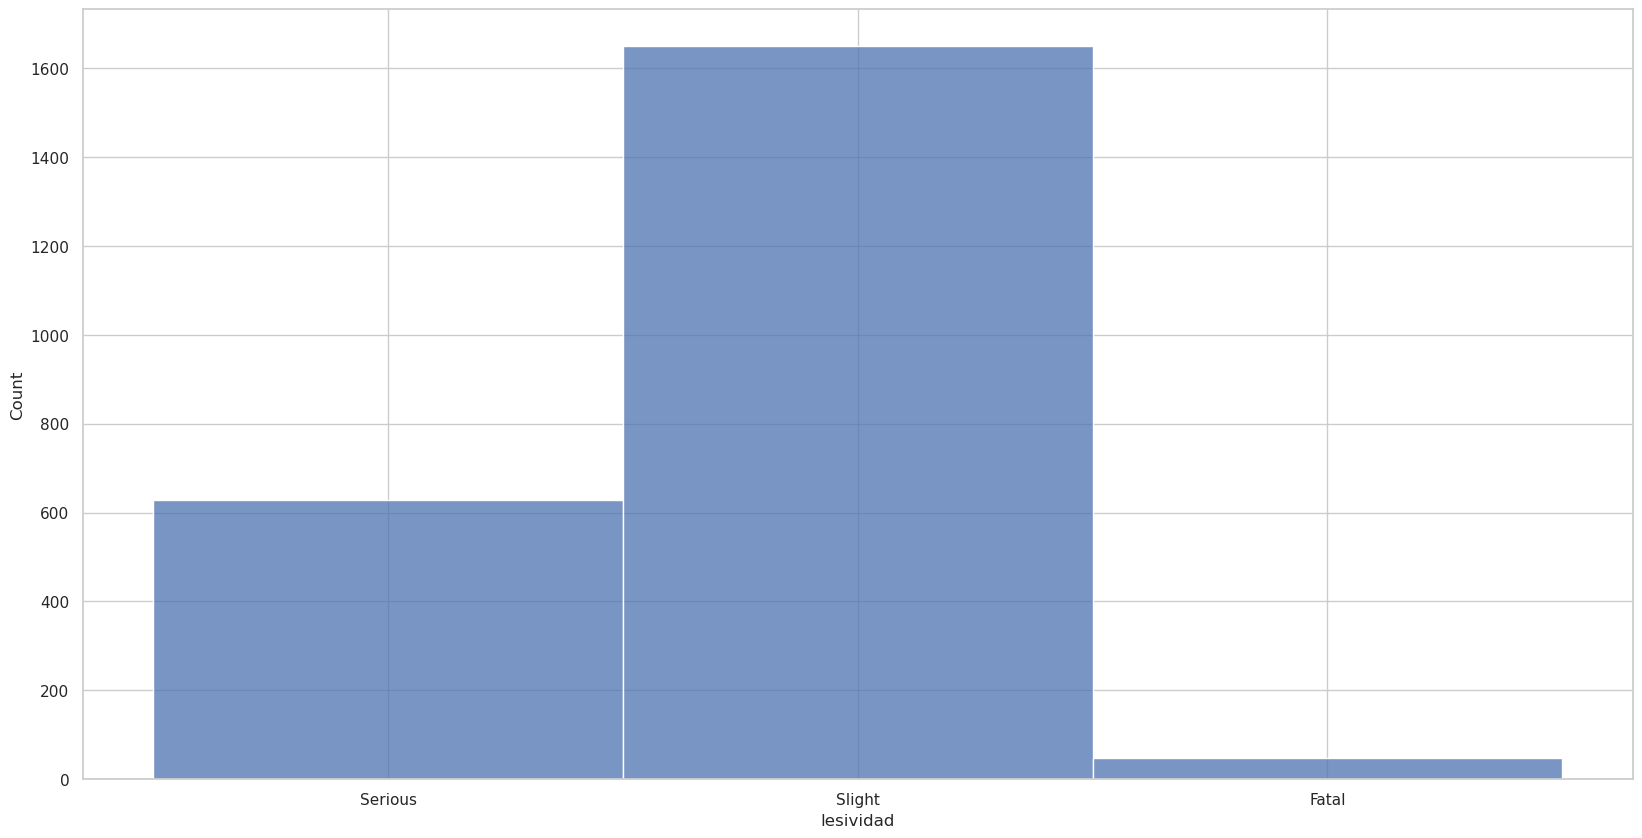

In [60]:
plt.figure(figsize=(20, 10))

sns.set_theme(style="whitegrid")
sns.histplot(data=data_frame.lesividad,stat='count')
# plt.savefig('histograms_images/original.svg')
# one_hot_to_casualty(Y_train).value_counts()

In [61]:
transf = {'Serious': 'Assistance',
          'Fatal': 'Assistance'}

data_frame.replace(transf, inplace=True)

## Split de datos

Histograma de desbalanceo

In [62]:
data_frame

,hora,tipo_carretera,distrito,tipo_accidente,estado_meteorológico,tipo_vehiculo,tipo_persona,rango_edad,sexo,lesividad,drogas_alcohol_positivo,vehiculos_implicados,dia_semana,semana_en_año,coordenada_x_utm,coordenada_y_utm
36047,2,17,11.0,5,1.0,5.0,1.0,3,1,Assistance,2,2,2,35,443767292,4464719193
36048,2,17,11.0,5,1.0,5.0,1.0,3,2,Slight,1,2,2,35,443767292,4464719193
50282,1,19,11.0,2,1.0,9.0,1.0,3,1,Slight,2,3,2,23,439229970,4464807550
50283,1,19,11.0,2,1.0,4.0,1.0,3,1,Assistance,2,3,2,23,439229970,4464807550
50284,1,19,11.0,2,1.0,4.0,2.0,3,1,Assistance,2,3,2,23,439229970,4464807550
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6928,1,19,10.0,2,1.0,5.0,1.0,3,2,Slight,2,2,3,14,443117112,4485057195
6929,1,19,10.0,2,1.0,5.0,1.0,3,1,Slight,2,2,3,14,443117112,4485057195
13958,1,19,10.0,2,1.0,4.0,1.0,2,1,Slight,2,2,3,27,443111445,4485054033
13959,1,19,10.0,2,1.0,5.0,1.0,3,1,Slight,2,2,3,27,443111445,4485054033


In [63]:
from sklearn.model_selection import train_test_split


train, test = train_test_split(data_frame, test_size=0.2, random_state = 2)
X_train = X_train_original = train.loc[:, ~train.columns.isin(['lesividad'])]

X_train = X_train.astype(int)
X_train_original = X_train_original.astype(int)

Y_train = Y_train_original = train['lesividad']

X_test = test.loc[:, ~test.columns.isin(['lesividad'])]
X_test = X_test.astype(int)
Y_test = test['lesividad']

Slight        1306
Assistance     554
Name: lesividad, dtype: int64

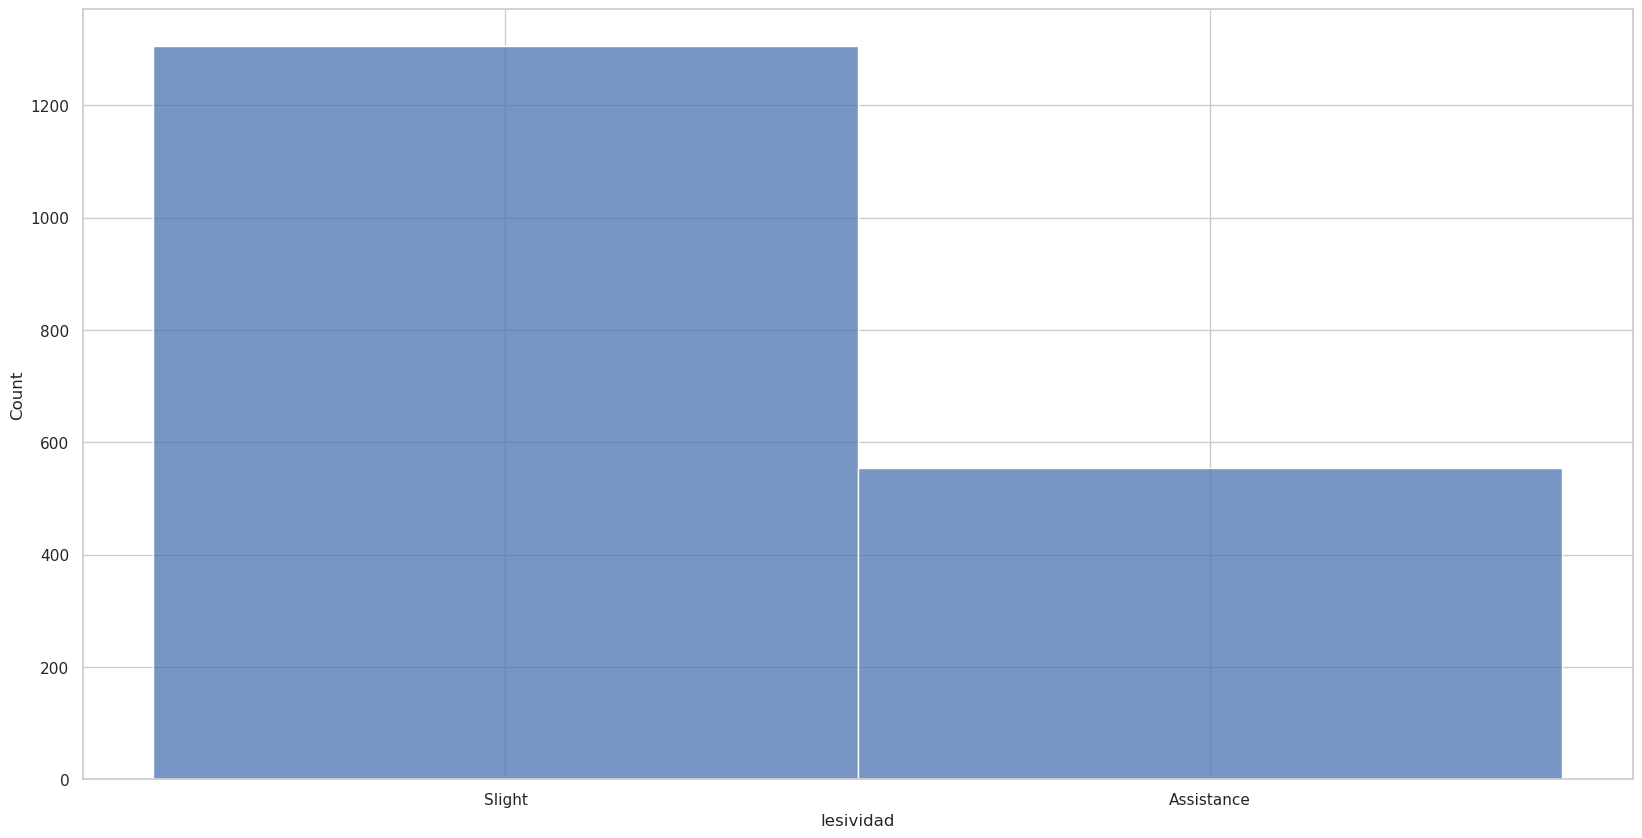

In [64]:
plt.figure(figsize=(20, 10))

sns.set_theme(style="whitegrid")
sns.histplot(data=one_hot_to_casualty(Y_train),stat='count')
plt.savefig('histograms_images/original.svg')
one_hot_to_casualty(Y_train).value_counts()

In [65]:
# # FILE_NAME = f"{city_name}_calculated_weights.json"
# FILE_NAME = 'madrid_adapted_leeds_default_weights.json'

# feature_vector = load_json(WEIGHTS_PATH, FILE_NAME)

In [66]:

# feature_vector = {}

# feature_vector['Accident Features'] = {
#     'feature_childs': ['coordenada_x_utm', 'coordenada_y_utm', 'distrito', 'hora', 'vehiculos_implicados'],
#     'feature_weights': [0.165774538, 0.171530785, 0.082228259, 0.047771472, 0.060763375]
# } 

# feature_vector['Roadway Features'] = {
#     'feature_childs': ['tipo_accidente'], # Road Surface 
#     'feature_weights': [0.07036541]
# }

# feature_vector['Environmental Features'] = {
#     'feature_childs': ['estado_meteorológico'],
#     'feature_weights': [0.04354843]
# }

# feature_vector['Vehicle Features'] = {
#     'feature_childs': ['tipo_vehiculo'],
#     'feature_weights': [0.126314657]
# }

# feature_vector['Casualty Features'] = {
#     'feature_childs': ['tipo_persona', 'sexo', 'rango_edad', 'drogas_alcohol_positivo'],
#     'feature_weights': [0.067057589, 0.049116389, 0.095220163, 0.059951354]
# } 
# matrix_indexes = fv2gi(feature_vector)

# # {'Accident Features': {'feature_childs': ['Easting',
# #    'Northing',
# #    '1st Road Class',
# #    'Accident Time',
# #    'Number of Vehicles'],
# #   'feature_weights': [0.165774538,
# #    0.171530785,
# #    0.082228259,
# #    0.047771472,
# #    0.060763375],
# #   'wpi': 0.528068429},
# #  'Roadway Features': {'feature_childs': ['Road Surface'],
# #   'feature_weights': [0.048847406],
# #   'wpi': 0.048847406},
# #  'Environmental Features': {'feature_childs': ['Lighting Conditions',
# #    'Weather Conditions'],
# #   'feature_weights': [0.041826936, 0.04354843],
# #   'wpi': 0.08537536600000001},
# #  'Vehicle Features': {'feature_childs': ['Type of Vehicle'],
# #   'feature_weights': [0.126314657],
# #   'wpi': 0.126314657},
# #  'Casualty Features': {'feature_childs': ['Casualty Class',
# #    'Sex of Casualty',
# #    'Age of Casualty'],
# #   'feature_weights': [0.067057589, 0.049116389, 0.095220163],
# #   'wpi': 0.211394141}}
# feature_vector

## Normalización de datos

In [67]:
X_train = X_train.astype(int)
X_test  = X_test.astype(int)

X_train_original = X_train_original.astype(int)

X_train = normalize_data(X_train)
X_train_original = normalize_data(X_train_original)
X_test  = normalize_data(X_test)

## Oversampling de datos

In [68]:
from oversampling_methods.taspcnn_cGAN import cGAN

# cGAN(X_train,Y_train,10)
# cGAN.call()

### SMOTE-II

In [69]:
# print('********** Before OverSampling **********')
# print('Slight: ', (Y_train == 'Slight').sum())
# print('Serious:', (Y_train == 'Serious').sum())
# print('Fatal:  ', (Y_train == 'Fatal').sum())
# print('\n Total X:', len(X_train), ' Total Y:', len(Y_train), '\n')

# X_train, Y_train = oversample_data(X_train, Y_train)

Slight        1306
Assistance     554
Name: lesividad, dtype: int64

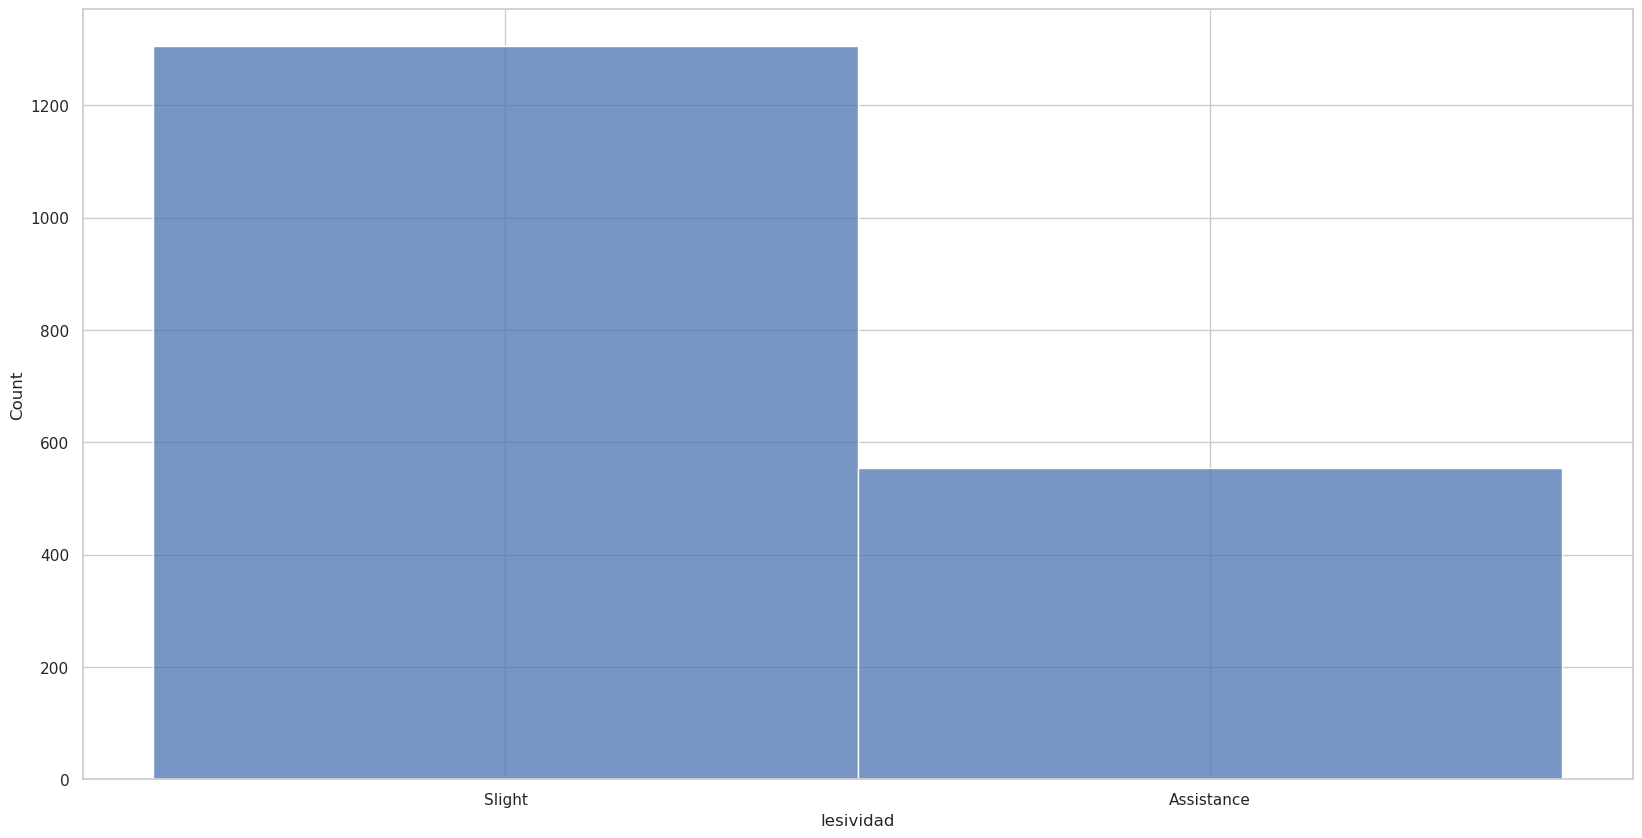

In [70]:
plt.figure(figsize=(20, 10))

sns.set_theme(style="whitegrid")
sns.histplot(data=one_hot_to_casualty(Y_train),stat='count')
plt.savefig('histograms_images/smote-ii.svg')
Y_train.value_counts()

## Downsampling de datos

### Two classes

In [71]:
from sklearn.model_selection import train_test_split

from sklearn.utils import resample

slight_data  = test[test['lesividad'] == 'Slight']
serious_data = test[test['lesividad'] == 'Assistance']
# fatal_data   = test[test['lesividad'] == 'Fatal']

X_slight_downsampled = resample(slight_data,
                                replace = True,
                                n_samples = len(serious_data))

# X_serious_downsampled = resample(serious_data,
#                                  replace = True,
#                                  n_samples = len(fatal_data))


downsampled_dataset = pd.concat([X_slight_downsampled, serious_data])

downsampled_train, downsampled_test = train_test_split(downsampled_dataset, test_size=0.2)

X_train_downsampled = downsampled_train.loc[:, ~downsampled_train.columns.isin(['lesividad'])]
Y_train_downsampled = downsampled_train['lesividad']

X_test_downsampled = downsampled_test.loc[:, ~downsampled_test.columns.isin(['lesividad'])]
Y_test_downsampled = downsampled_test['lesividad']

### Three Classes

In [72]:
# from sklearn.model_selection import train_test_split

# from sklearn.utils import resample

# slight_data  = test[test['lesividad'] == 'Slight']
# serious_data = test[test['lesividad'] == 'Serious']
# fatal_data   = test[test['lesividad'] == 'Fatal']

# X_slight_downsampled = resample(slight_data,
#                                 replace = True,
#                                 n_samples = len(fatal_data))

# X_serious_downsampled = resample(serious_data,
#                                  replace = True,
#                                  n_samples = len(fatal_data))


# downsampled_dataset = pd.concat([X_slight_downsampled, X_serious_downsampled, fatal_data])

# downsampled_train, downsampled_test = train_test_split(downsampled_dataset, test_size=0.2)

# X_train_downsampled = downsampled_train.loc[:, ~downsampled_train.columns.isin(['lesividad'])]
# Y_train_downsampled = downsampled_train['lesividad']

# X_test_downsampled = downsampled_test.loc[:, ~downsampled_test.columns.isin(['lesividad'])]
# Y_test_downsampled = downsampled_test['lesividad']

In [73]:
# plt.figure(figsize=(20, 10))

# sns.set_theme(style="whitegrid")
# sns.histplot(data=one_hot_to_casualty(Y_test_downsampled),stat='count')
# plt.savefig('histograms_images/downsampled-test.svg')
# Y_test_downsampled.value_counts()


# plt.figure(figsize=(20, 10))

# sns.set_theme(style="whitegrid")
# sns.histplot(data=one_hot_to_casualty(Y_train_downsampled),stat='count')
# plt.savefig('histograms_images/downsampled-train.svg')
# Y_train_downsampled.value_counts()

In [74]:
X_train = X_train.astype(int)
X_test  = X_test.astype(int)

X_train_original = X_train_original.astype(int)

X_train_downsampled = X_train_downsampled.astype(int)
X_test_downsampled  = X_test_downsampled.astype(int)

X_train = normalize_data(X_train)
X_test  = normalize_data(X_test)
X_train_downsampled = normalize_data(X_train_downsampled)
X_test_downsampled  = normalize_data(X_test_downsampled)

In [75]:
X_train, X_val, Y_train, Y_val = train_test_split(X_train, Y_train, test_size=0.2, random_state = 2)

## XGBoost

In [76]:
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score
from hyperopt import STATUS_OK, Trials, fmin, hp, tpe

from xgboost import XGBClassifier
import xgboost as xgb
import time


### Genético

In [77]:
if calculate_weights:
    Y_train_downsampled_copy = Y_train_downsampled.copy()
    Y_test_downsampled_copy  = Y_test_downsampled.copy()
    Y_test_copy = Y_test.copy()
    Y_val_copy  = Y_val.copy()
    Y_train_copy = Y_train.copy()

    Y_train_downsampled_onehot = casualty_to_one_hot(Y_train_downsampled_copy)
    Y_test_downsampled_onehot  = casualty_to_one_hot(Y_test_downsampled_copy)
    Y_val_onehot  = casualty_to_one_hot(Y_val_copy)
    Y_test_onehot  = casualty_to_one_hot(Y_test_copy)
    Y_train_onehot  = casualty_to_one_hot(Y_train_copy)

    populationSize = (number_of_individuals, number_of_hyperparams)
    population = initialize_population(number_of_individuals   = number_of_individuals,
                                       hyperparams_to_optimize = HYPERPARAMS_TO_OPTIMIZE)

    fitnessHistory = np.empty([number_of_generations+1, number_of_individuals]) # Define an array to store the value of each parameter for each parent and generation
    populationHistory = np.empty([(number_of_generations+1)*number_of_individuals, number_of_hyperparams]) # Insert the value of initial parameters in history

    best_solution_history = np.empty([(number_of_generations), number_of_hyperparams+1])
    populationHistory[0:number_of_individuals,:] = population

    dtrain = xgb.DMatrix(data  = X_train,
                         label = Y_train_copy)

    dtest  = xgb.DMatrix(data  = X_test, 
                         label = Y_test_copy)

    for generation in range(number_of_generations):

        print("This is number %s generation" % (generation))

        new_population = []

        unique_individuals = np.unique(population, axis=0)

        new_individuals_to_create = number_of_individuals - len(unique_individuals)

        for i in range(new_individuals_to_create):
            new_individual = generate_individual(hyperparams_to_optimize = HYPERPARAMS_TO_OPTIMIZE)
            new_population.append(new_individual)

        new_population = np.array(new_population)

        if (new_individuals_to_create):
            population = np.concatenate((unique_individuals, new_population), axis=0)

        # print(f'Current population is {population}')
        print(f'New population is {len(new_population)}')

        # Train the dataset and obtain fitness
        fitnessValue = train_population(population = population,
                                        hyperparams_to_optimize = HYPERPARAMS_TO_OPTIMIZE,
                                        dMatrixTrain = dtrain,
                                        dMatrixTest = dtest,
                                        Y_test = Y_test_copy)

        fitnessHistory[generation,:] = fitnessValue

        # Best score in the current iteration
        max_score_index = np.argmax(fitnessHistory[generation,:])
        max_score_value = np.max(fitnessHistory[generation,:])
        max_score_solution = population[max_score_index]

        max_solution_with_score = []
        max_solution_with_score = np.append(max_score_solution, max_score_value)
        best_solution_history[generation] = max_solution_with_score

        print(f"Best F1 score in the this iteration = {max_score_value}, best solution {max_score_solution}") # Survival of the fittest - take the top parents, based on the fitness value and number of parents needed to be selected

        parents = new_parents_selection(population = population,
                                        fitness = fitnessValue,
                                        numParents = numberOfParentsMating)

        # Mate these parents to create children having parameters from these parents (we are using uniform crossover)
        children = crossover_uniform(parents = parents,
                                     childrenSize = (populationSize[0] - parents.shape[0], number_of_hyperparams))

        # Add mutation to create genetic diversity
        children_mutated = mutation(children,
                                    hyperparams_to_optimize = HYPERPARAMS_TO_OPTIMIZE)

        '''
        We will create new population, which will contain parents that where selected previously based on the
        fitness score and rest of them  will be children
        '''
        population[0:parents.shape[0], :] = parents # Fittest parents
        population[parents.shape[0]:, :]  = children_mutated # Children

        populationHistory[(generation+1)*number_of_individuals : (generation+1)*number_of_individuals + number_of_individuals , :] = population # Store parent information

    #Best solution from the final iteration

    fitness = train_population(population = population,
                               hyperparams_to_optimize = HYPERPARAMS_TO_OPTIMIZE,
                               dMatrixTrain = dtrain,
                               dMatrixTest = dtest,
                               Y_test = Y_test_copy)

    fitnessHistory[generation+1, :] = fitness # index of the best solution
    bestFitnessIndex = np.where(fitness == np.max(fitness))[0][0]


    best_hyperparams = {}
    for n_param, hyperparam in enumerate(HYPERPARAMS_TO_OPTIMIZE):
        best_hyperparams[hyperparam] = population[bestFitnessIndex][n_param]

In [78]:
if calculate_weights and madrid:
    #### PLOT FITNESS EVOLUTION ####
    x_fitness = [np.max(fitnessHistory[i]) for i in range(0,fitnessHistory.shape[0])]

    FILE_NAME = f"{city_name}_ga_{MODEL_TIMESTAMP}.svg"

    plt.figure(figsize=(15, 8))
    plt.ylabel('F1-Score')
    plt.xlabel('Iterations')
    plt.plot(np.arange(len(x_fitness)), x_fitness)
    plt.savefig(GA_SCORES_PATH + FILE_NAME)

    #### PLOT HYPERPARAMS EVOLUTION ####
    FILE_NAME = f"{city_name}_ga_hyperparams_evolution_p{number_of_individuals}_c{numberOfParentsMating}_{MODEL_TIMESTAMP}.svg"

    LEGEND_LABELS = HYPERPARAMS_TO_OPTIMIZE.keys()

    plt.figure(figsize=(15, 8))
    best_solution_history_aux = best_solution_history
    best_solution_history_aux[:,1] = best_solution_history[:,1]/2
    best_solution_history_aux[:,3] = best_solution_history[:,3]/100
    plt.plot(best_solution_history_aux[:,:3])
    plt.ylabel('Factor')
    plt.xlabel('Iterations')
    plt.legend(LEGEND_LABELS)
    plt.savefig(HYPERPARAMS_EVOLUTON_PATH + FILE_NAME, dpi=300)

    FILE_NAME = f"{city_name}_population_p{number_of_individuals}_c{numberOfParentsMating}_{MODEL_TIMESTAMP}.txt"

    np.savetxt(FINAL_POPULATION_PATH + FILE_NAME, population, fmt='%s')



In [79]:
# # best_solution_history_2 = best_solution_history.copy()
# # best_solution_history_2 =  np.append([[0, 0, 0]] ,best_solution_history)

FILE_NAME = "save2.json"

# # np.savetxt(FILE_NAME, best_solution_history, fmt='%s')
vector = load_json('./', FILE_NAME)
with open(FILE_NAME) as json_file:
    data = json.load(json_file)

In [80]:
np_array_to_append = [ [0.02, 4.0, 1.6099999999999999, 0.007437]]*30
np_array_to_append = np.asarray(np_array_to_append)
data = np.asarray(data)

In [81]:
data = np.concatenate([data, np_array_to_append])

In [82]:
new_array = []
for one_list in data:
    new_array.append(np.asarray(one_list))

new_array = np.asarray(new_array)

In [83]:
# for i in range(0,4):
#     print(i)

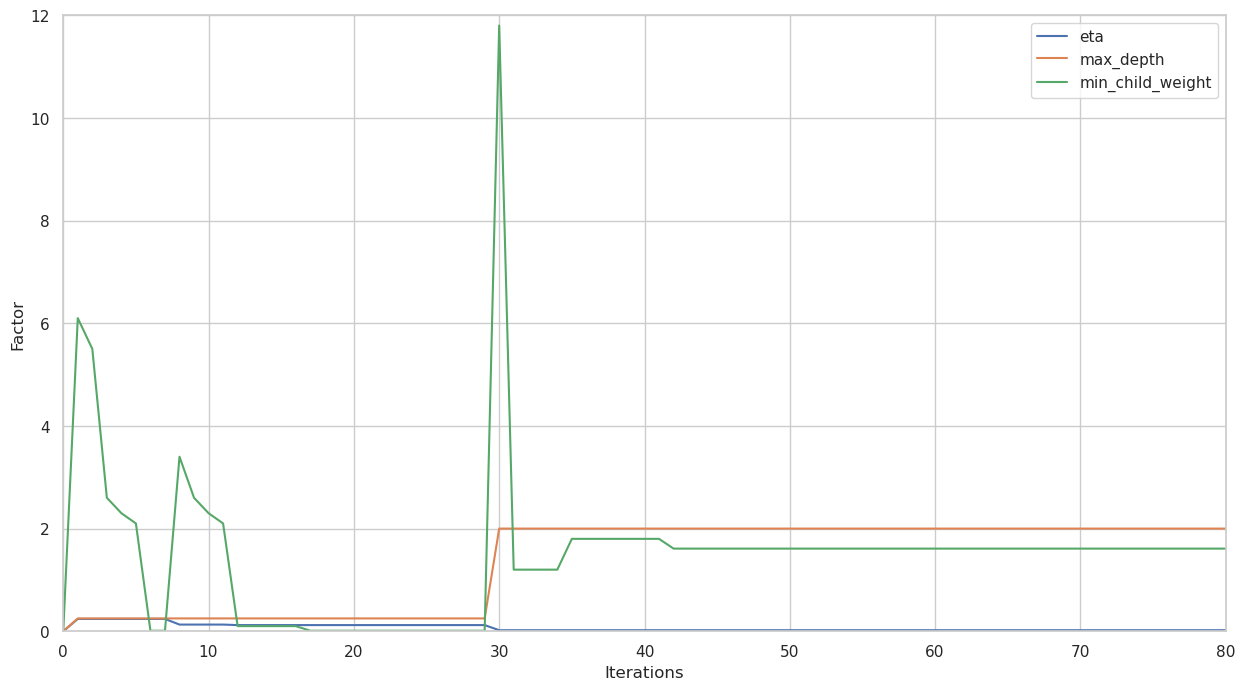

In [84]:
LEGEND_LABELS = HYPERPARAMS_TO_OPTIMIZE.keys()

vector = np.array(data).reshape(-1, 4)

vector[:,1] = vector[:,1]/2
vector[:,3] = vector[:,3]/100

plt.figure(figsize=(15, 8))
    
for i in range(0,3):
    plt.plot(vector[:,i])

    plt.ylabel('Factor')
    plt.xlabel('Iterations')
    plt.legend(LEGEND_LABELS)
    plt.ylim(ymin=0, ymax=12)
    plt.xlim(xmin=0, xmax=80)

    plt.savefig('new.svg', dpi=300)

In [85]:
# data

### Hiperparámetros

- [Bayesian Optimization with HYPEROPT](https://www.kaggle.com/code/prashant111/a-guide-on-xgboost-hyperparameters-tuning/notebook)

#### Carga hiperparámetros

In [86]:
if not calculate_weights and city:

    # FILE_NAME = f"{city_name}_hyperparams{loaded_timestamp}.json"
    FILE_NAME = f"{city_name}_hyperparams2023-04-22-14:13:41.json"

    best_hyperparams = load_json(f"{HYPERPARAMS_PATH}{city_name}/", FILE_NAME)

# # # 0.875 GA
# # # 0.04, 1, 3.9, 900
# # # best_hyperparams = {}
# # # best_hyperparams['eta'] = 0.04
# # # best_hyperparams['max_depth'] = 1
# # # best_hyperparams['min_child_weight'] = 3.9
# # # best_hyperparams['n_estimators'] = 900

#### Escritura hiperparámetros

In [87]:
if calculate_weights and city:
    FILE_NAME = f"{city_name}_hyperparams{MODEL_TIMESTAMP}.json"

    write_json(best_hyperparams, f"{HYPERPARAMS_PATH}{city_name}/", FILE_NAME)
    print(best_hyperparams)

### Pesos de características

#### Carga definitiva/auxiliar de pesos

In [88]:
# FILE_NAME = 'madrid_adapted_leeds_default_weights.json'
# # FILE_NAME = 'madrid_weights_no_roadClass.json'
FILE_NAME = f"{city_name}_weights{loaded_timestamp}.json"

feature_vector = load_json(WEIGHTS_PATH, FILE_NAME)


FILE_NAME =  f"{city_name}_weights2023-04-22-14:13:41.json"


feature_vector = load_json(WEIGHTS_PATH, FILE_NAME)
########## 17-05-2022 ##########
# Se ha cambiado 1stRoadClass (distrito) a RoadwayFeatures --> EN LEEDS NO ES ASÍ, PERO PARA Mí TIENE SENTIDO
# Se ha cambiado tipo accidente de RoadwayFeatures a Accident --> EN LEEDS NO EXISTE ESTE CAMPO, PERO PARA Mí TIENE SENTIDO
# feature_vector = {'Accident Features': {'feature_childs': ['coordenada_x_utm',
#    'coordenada_y_utm',
#    'hora',
#    'vehiculos_implicados',
#    'tipo_accidente'],
#   'feature_weights': ['0.03979435',
#    '0.061120145',
#    '0.02675103',
#    '0.083673365',
#    '0.03753465'],
#   'wpi': 0.255731688},
#  'Roadway Features': {'feature_childs': ['distrito', 'tipo_carretera'],
#   'feature_weights': ['0.044392798', '9999.9'],
#   'wpi': 0.03753465},
#  'Environmental Features': {'feature_childs': ['estado_meteorológico'],
#   'feature_weights': ['0.024665328'],
#   'wpi': 0.024665328},
#  'Vehicle Features': {'feature_childs': ['tipo_vehiculo'],
#   'feature_weights': ['0.048645806'],
#   'wpi': 0.048645806},
#  'Casualty Features': {'feature_childs': ['tipo_persona',
#    'sexo',
#    'rango_edad',
#    'drogas_alcohol_positivo'],
#   'feature_weights': ['0.2764425', '0.2201619', '0.06879471', '0.03230864'],
#   'wpi': 0.59770775}}


#### Cálculo de pesos de caracetrísticas

In [89]:
if calculate_weights and city:
    best_hyperparams['max_depth'] =  int(best_hyperparams['max_depth'])

    xgboost = XGBClassifier(**best_hyperparams,
                            tree_method = tree_method,
                            single_precision_histogram =  True)

    xgboost.fit(X_train, Y_train_onehot)

    child_weights  = np.array(xgboost.feature_importances_)
    feature_vector = fill_feature_vector(X_train, child_weights)

In [90]:
feature_vector

{'Accident Features': {'feature_childs': ['coordenada_x_utm',
   'coordenada_y_utm',
   'distrito',
   'hora',
   'vehiculos_implicados'],
  'feature_weights': ['0.033661336',
   '0.034528688',
   '0.021336874',
   '0.062376298',
   '0.09423137'],
  'wpi': 0.246134566},
 'Roadway Features': {'feature_childs': ['tipo_accidente'],
  'feature_weights': ['0.04550401'],
  'wpi': 0.04550401},
 'Environmental Features': {'feature_childs': ['estado_meteorológico',
   'semana_en_año',
   'dia_semana'],
  'feature_weights': ['0.016438562', '0.028085757', '0.031229725'],
  'wpi': 0.07575404399999999},
 'Vehicle Features': {'feature_childs': ['tipo_vehiculo'],
  'feature_weights': ['0.053042557'],
  'wpi': 0.053042557},
 'Casualty Features': {'feature_childs': ['tipo_persona',
   'sexo',
   'rango_edad',
   'drogas_alcohol_positivo'],
  'feature_weights': ['0.4346352',
   '0.053416684',
   '0.027660728',
   '0.024659676'],
  'wpi': 0.5403722879999999}}

#### Visualización pesos calculados

In [91]:
if calculate_weights and city:
    FILE_NAME = f"{city_name}_figure_weights_{MODEL_TIMESTAMP}.svg"

    print(xgboost.get_booster().get_score(importance_type= 'weight'))
    plt.figure(figsize=(10, 5))
    plt.barh(X_train_downsampled.columns, xgboost.feature_importances_)
    plt.savefig(WEIGHTS_PATH + FILE_NAME)

    print(xgboost.feature_importances_)

    for column, weight in zip(X_train_downsampled.columns,xgboost.feature_importances_):
      print(column, weight)

    child_weights  = np.array(xgboost.feature_importances_)
    feature_vector = fill_feature_vector(X_train_downsampled, child_weights)

#### Escritura de pesos de características

- v5: Pesos calculados con hiperparámetros. En el dataset están tipificados los vehículos como en el artículo, las edades no están en rango.
- v6: Pesos calculados con hiperparámetros. En el dataset están tipificados los vehículos como en el artículo, las edades están en rango.
- v7: hiperparams, tipos de carretera tipificados por vía.

In [92]:
if calculate_weights and madrid:
    matrix_indexes = fv2gi(feature_vector)

    FILE_NAME = f"{city_name}_weights{MODEL_TIMESTAMP}.json"
    # FILE_NAME = 'default_calculated_weights.json'

    write_json(feature_vector, WEIGHTS_PATH, FILE_NAME)

In [93]:
feature_vector

{'Accident Features': {'feature_childs': ['coordenada_x_utm',
   'coordenada_y_utm',
   'distrito',
   'hora',
   'vehiculos_implicados'],
  'feature_weights': ['0.033661336',
   '0.034528688',
   '0.021336874',
   '0.062376298',
   '0.09423137'],
  'wpi': 0.246134566},
 'Roadway Features': {'feature_childs': ['tipo_accidente'],
  'feature_weights': ['0.04550401'],
  'wpi': 0.04550401},
 'Environmental Features': {'feature_childs': ['estado_meteorológico',
   'semana_en_año',
   'dia_semana'],
  'feature_weights': ['0.016438562', '0.028085757', '0.031229725'],
  'wpi': 0.07575404399999999},
 'Vehicle Features': {'feature_childs': ['tipo_vehiculo'],
  'feature_weights': ['0.053042557'],
  'wpi': 0.053042557},
 'Casualty Features': {'feature_childs': ['tipo_persona',
   'sexo',
   'rango_edad',
   'drogas_alcohol_positivo'],
  'feature_weights': ['0.4346352',
   '0.053416684',
   '0.027660728',
   '0.024659676'],
  'wpi': 0.5403722879999999}}

### Cálculo índices de matriz

In [94]:
if city:
    matrix_indexes = fv2gi(feature_vector)

In [95]:
matrix_indexes

{'tipo_persona': [2, 2],
 'sexo': [2, 1],
 'rango_edad': [2, 3],
 'drogas_alcohol_positivo': [2, 0],
 'vehiculos_implicados': [1, 2],
 'hora': [1, 1],
 'coordenada_y_utm': [1, 3],
 'coordenada_x_utm': [1, 0],
 'distrito': [1, 4],
 'dia_semana': [3, 2],
 'semana_en_año': [3, 1],
 'estado_meteorológico': [3, 3],
 'tipo_vehiculo': [0, 2],
 'tipo_accidente': [4, 2]}

## Construcción de imágenes

In [96]:
if city:

    train_bgi = build_gray_images(X_train, 5, matrix_indexes)
    train_original_bgi = build_gray_images(X_train_original, 5, matrix_indexes)

    # val_bgi  = build_gray_images(X_val, 5, matrix_indexes)
    test_bgi = build_gray_images(X_test, 5, matrix_indexes)

    pd.DataFrame(train_bgi[:,:,1057])

1488
1860
466


## Reshape de imágenes

In [97]:
if city:

    train_images = shape_images(X_data = X_train,
                            gray_images = train_bgi)

    train_original_images = shape_images(X_data = X_train_original,
                                         gray_images = train_original_bgi)

    # val_images  = shape_images(X_data = X_val,
    #                            gray_images = val_bgi)

    test_images  = shape_images(X_data = X_test,
                                gray_images = test_bgi)

In [98]:
train_bgi[:,:,-1]

array([[ 0.        ,  0.        , -0.20068262,  0.        ,  0.        ],
       [ 0.0128783 , -0.86304144, -1.59491487,  0.00860316,  0.00832392],
       [ 0.16448974, -0.62559357, -0.35483516,  0.17571709,  0.        ],
       [ 0.        , -0.01744858,  1.3337635 , -0.23082999,  0.        ],
       [ 0.        ,  0.        , -1.62105824,  0.        ,  0.        ]])

/tmp/ipykernel_13393/1646512721.py:7: MatplotlibDeprecationWarning: The 'b' parameter of grid() has been renamed 'visible' since Matplotlib 3.5; support for the old name will be dropped two minor releases later.
  plt.grid(b=None)


<Figure size 640x480 with 0 Axes>

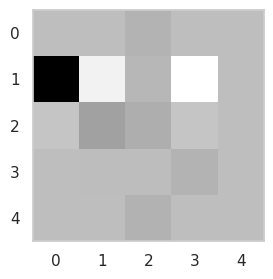

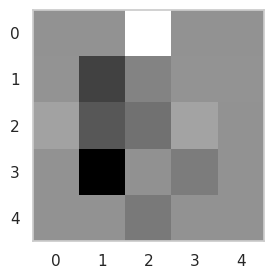

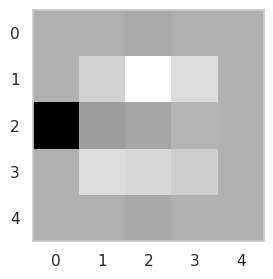

In [99]:
if city:

    sns.set_theme(style="whitegrid")
    plt.gray()
    for i in range(100,103):
        plt.figure(figsize=(3, 3))
        plt.grid(b=None)
        plt.imshow(train_bgi[:,:,i+6])
        # plt.savefig(f"{city_name}_image_example_{i}.svg",transparent=True)
        plt.show()


## CT-GAN

In [100]:
train

,hora,tipo_carretera,distrito,tipo_accidente,estado_meteorológico,tipo_vehiculo,tipo_persona,rango_edad,sexo,lesividad,drogas_alcohol_positivo,vehiculos_implicados,dia_semana,semana_en_año,coordenada_x_utm,coordenada_y_utm
37789,1,17,5.0,2,3.0,4.0,1.0,3,1,Slight,2,2,5,40,450372588,4468760639
16586,1,3,4.0,6,1.0,4.0,1.0,2,1,Slight,2,1,5,33,441448638,4475250886
14527,1,19,6.0,2,1.0,3.0,1.0,3,1,Assistance,2,2,5,28,439658107,4476310281
49710,1,3,10.0,2,1.0,5.0,1.0,3,2,Slight,2,6,7,21,439903990,4481307910
42715,1,19,10.0,2,1.0,5.0,1.0,3,2,Slight,2,2,7,53,441011950,4480715140
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
20511,1,19,15.0,0,3.0,3.0,1.0,2,1,Assistance,2,2,1,42,442790157,4474731990
53289,2,17,19.0,6,1.0,3.0,1.0,3,1,Slight,2,2,4,30,442938040,4471234000
42956,2,17,15.0,4,1.0,1.0,1.0,2,1,Assistance,2,2,6,2,442433950,4472704660
7325,1,3,0.0,2,1.0,5.0,1.0,3,1,Slight,2,2,1,15,441306958,4474818829


In [101]:
transf = {
    'Slight': 0,
    'Assistance': 1
}   

train = train.replace(transf)

In [102]:
from ctgan import CTGAN

train['distrito'] = train['distrito'].astype(int)
train['estado_meteorológico'] = train['estado_meteorológico'].astype(int)
train['tipo_vehiculo'] = train['tipo_vehiculo'].astype(int)
train['tipo_persona'] = train['tipo_persona'].astype(int)
train['dia_semana'] = train['tipo_persona'].astype(int)
train['semana_en_año'] = train['tipo_persona'].astype(int)
train['coordenada_x_utm'] = train['coordenada_x_utm'].astype(float)
train['coordenada_y_utm'] = train['coordenada_y_utm'].astype(float)
train['lesividad'] = train['lesividad'].astype(int)

ctgan = CTGAN(epochs=10)
# ctgan.fit(train, ['lesividad'], epochs=1500)

# Create synthetic data
# synthetic_data = ctgan.sample(1000)

In [103]:
# synthetic_data.lesividad.value_counts()

## C-GAN

In [104]:
# batch_size = 64
# num_channels = 1
# num_classes = 2
# image_size = 8
# latent_dim = 32
# epochs = 150

In [105]:
# transf = {
#     'Slight': 0,
#     'Assistance': 1
# }   

# Y_train_categorical = Y_train.replace(transf)
# Y_test_categorical = Y_test.replace(transf)

In [106]:
# # We'll use all the available examples from both the training and test
# # sets.
# # (x_train, y_train), (x_test, y_test) = keras.datasets.mnist.load_data()

# all_train = np.concatenate([train_images, test_images])
# npad = ((0, 0), (1, 2), (1, 2),(0,0))
# all_train = np.pad(all_train, pad_width=npad, mode='constant', constant_values=0)
# all_labels = np.concatenate([Y_train_categorical, Y_test_categorical])

# # Scale the pixel values to [0, 1] range, add a channel dimension to
# # the images, and one-hot encode the labels.
# all_train = all_train.astype("float32")
# all_train = np.reshape(all_train, (-1, 8, 8, 1))
# all_labels = keras.utils.to_categorical(all_labels, num_classes)

# # Create tf.data.Dataset.
# dataset = tf.data.Dataset.from_tensor_slices((all_train, all_labels))
# dataset = dataset.shuffle(buffer_size=1024).batch(batch_size)

# print(f"Shape of training images: {all_train.shape}")
# print(f"Shape of training labels: {all_labels.shape}")


In [107]:
# from tensorflow import keras

# generator_in_channels = latent_dim + num_classes
# discriminator_in_channels = num_channels + num_classes
# print(generator_in_channels, discriminator_in_channels)

# # Create the discriminator.
# discriminator = keras.Sequential(
#     [
#         keras.layers.InputLayer((8, 8, discriminator_in_channels)),
#         layers.Conv2D(4, (2, 2), strides=(2, 2), padding="same"),
#         layers.LeakyReLU(alpha=0.2),
#         layers.Conv2D(4, (2, 2), strides=(3, 3), padding="same"),
#         layers.LeakyReLU(alpha=0.2),
#         layers.GlobalMaxPooling2D(),
#         layers.Dense(1),
#     ],
#     name="discriminator",
# )

# # Create the generator.
# generator = keras.Sequential(
#     [
#         keras.layers.InputLayer((generator_in_channels,)),
#         # We want to generate 128 + num_classes coefficients to reshape into a
#         # 7x7x(128 + num_classes) map.
#         layers.Dense(8 * 8 * generator_in_channels),
#         layers.LeakyReLU(alpha=0.2),
#         layers.Reshape((2, 2, generator_in_channels)),
#         layers.Conv2DTranspose(16, (2,2), strides=(1, 1), padding="same"),
#         layers.LeakyReLU(alpha=0.2),
#         layers.Conv2DTranspose(16, (2,2), strides=(1, 1), padding="same"),
#         layers.LeakyReLU(alpha=0.2),
#         layers.Conv2DTranspose(32, (2,2), strides=(1, 1), padding="same"),
#         layers.LeakyReLU(alpha=0.2),
#         layers.Conv2D(1, (2, 2), padding="same", activation="sigmoid"),
#     ],
#     name="generator",
# )

# cond_gan = ConditionalGAN(
#     discriminator=discriminator, generator=generator, latent_dim=latent_dim
# )

# cond_gan.compile(
#     d_optimizer=keras.optimizers.Adam(learning_rate=0.0001),
#     g_optimizer=keras.optimizers.Adam(learning_rate=0.0003),
#     loss_fn=keras.losses.BinaryCrossentropy(from_logits=True),
# )

# cond_gan.fit(dataset, epochs=epochs)

In [108]:
# import imageio
# from tensorflow_docs.vis import embed

# # We first extract the trained generator from our Conditiona GAN.
# trained_gen = cond_gan.generator

# # Choose the number of intermediate images that would be generated in
# # between the interpolation + 2 (start and last images).
# num_interpolation = 2  # @param {type:"integer"}

# # Sample noise for the interpolation.
# interpolation_noise = tf.random.normal(shape=(1, latent_dim))
# interpolation_noise = tf.repeat(interpolation_noise, repeats=num_interpolation)
# interpolation_noise = tf.reshape(interpolation_noise, (num_interpolation, latent_dim))


# def interpolate_class(first_number, second_number):
#     # Convert the start and end labels to one-hot encoded vectors.
#     first_label = keras.utils.to_categorical([first_number], num_classes)
#     second_label = keras.utils.to_categorical([second_number], num_classes)
#     first_label = tf.cast(first_label, tf.float32)
#     second_label = tf.cast(second_label, tf.float32)

#     # Calculate the interpolation vector between the two labels.
#     percent_second_label = tf.linspace(0, 1, num_interpolation)[:, None]
#     percent_second_label = tf.cast(percent_second_label, tf.float32)
#     interpolation_labels = (
#         first_label * (1 - percent_second_label) + second_label * percent_second_label
#     )

#     # Combine the noise and the labels and run inference with the generator.
#     noise_and_labels = tf.concat([interpolation_noise, interpolation_labels], 1)
#     fake = trained_gen.predict(noise_and_labels)
#     return fake


# start_class = 0  # @param {type:"slider", min:0, max:9, step:1}
# end_class = 1  # @param {type:"slider", min:0, max:9, step:1}

# fake_images = interpolate_class(start_class, end_class)

# # fake_images *= 255.0
# converted_images = fake_images.astype(np.float)
# converted_images = tf.image.resize(converted_images, (96, 96)).numpy().astype(np.uint8)
# imageio.mimsave("animation.gif", converted_images, fps=1)
# embed.embed_file("animation.gif")


In [109]:
# plt.imshow(train_images[0])
# # plt.savefig(f"{city_name}_image_example_{i}.svg",transparent=True)
# plt.show()

In [110]:
# plt.figure(figsize=(3, 3))
# plt.grid(b=None)
# plt.imshow(fake_images[0])
# # plt.savefig(f"{city_name}_image_example_{i}.svg",transparent=True)
# plt.show()


In [111]:
# train_images = shape_images(X_data = X_train,
#                             gray_images = train_bgi)
# test_images  = shape_images(X_data = X_test,
#                             gray_images = test_bgi)

## Visualización de datos

In [112]:
# !conda install -c anaconda seaborn --y

### Matriz de correlación

In [113]:
# p

In [114]:
# data_frame = ['', '', '', '', 'Weather conditions', 'Vehicle']
# correlation_matrix(data_frame)

### PCA

In [115]:
# pca(X_train, X_test)

### TSNE

In [116]:
if city:
    n_samples = 150
    index_slight  = Y_train[Y_train == 'Slight'][:n_samples].index
    index_serious = Y_train[Y_train == 'Serious'][:n_samples].index
    index_fatal   = Y_train[Y_train == 'Fatal'][:n_samples].index

In [117]:
if city:

    # Get same number of class samples from SMOTEII
    X_slight_train_tsne  = X_train.loc[index_slight]
    X_serious_train_tsne = X_train.loc[index_serious]
    X_fatal_train_tsne   = X_train.loc[index_fatal]

    X_train_tsne = pd.concat([X_slight_train_tsne, X_serious_train_tsne, X_fatal_train_tsne])

    Y_slight_train_tsne  = Y_train[index_slight]
    Y_serious_train_tsne = Y_train[index_serious]
    Y_fatal_train_tsne   = Y_train[index_fatal]

    Y_train_tsne = pd.concat([Y_slight_train_tsne, Y_serious_train_tsne, Y_fatal_train_tsne])

In [118]:
if city:

    n_samples = len(Y_train_original[Y_train_original == 'Fatal'])

    index_slight  = Y_train_original[Y_train_original == 'Slight'][:n_samples].index
    index_serious = Y_train_original[Y_train_original == 'Serious'][:n_samples].index
    index_fatal   = Y_train_original[Y_train_original == 'Fatal'][:n_samples].index

In [119]:
if city:

    # Get same number of class samples from original
    X_slight_clean_tsne  = X_train_original.loc[index_slight]
    X_serious_clean_tsne = X_train_original.loc[index_serious]
    X_fatal_clean_tsne   = X_train_original.loc[index_fatal]

    X_clean_tsne = pd.concat([X_slight_clean_tsne, X_serious_clean_tsne, X_fatal_clean_tsne])

    Y_slight_clean_tsne  = Y_train_original[index_slight]
    Y_serious_clean_tsne = Y_train_original[index_serious]
    Y_fatal_clean_tsne   = Y_train_original[index_fatal]

    Y_clean_tsne = pd.concat([Y_slight_clean_tsne, Y_serious_clean_tsne, Y_fatal_clean_tsne])

In [120]:
if tsne and city:
    FILE_NAME = f"{TSNE_PATH}{city_name}/2d_tsne_clean.svg"
    plot_TSNE(X_clean_tsne, Y_clean_tsne, n_components = 2, output_file_name = FILE_NAME, title = 'Muestras originales 2 Componentes')

    FILE_NAME = f"{TSNE_PATH}{city_name}/3d_tsne_clean.svg"
    plot_TSNE(X_clean_tsne, Y_clean_tsne, n_components = 3, output_file_name = FILE_NAME, title = 'Muestras originales 3 Componentes')

    FILE_NAME = f"{TSNE_PATH}{city_name}/2d_tsne_train.svg"
    plot_TSNE(X_train_tsne, Y_train_tsne, n_components = 2, output_file_name = FILE_NAME, title = 'Muestras SMOTE-II 2 Componentes')

    FILE_NAME = f"{TSNE_PATH}{city_name}/3d_tsne_train.svg"
    plot_TSNE(X_train_tsne, Y_train_tsne, n_components = 3, output_file_name = FILE_NAME, title = 'Muestras SMOTE-II 3 Componentes')

### Autoencoder

#### Entrenamiento

In [121]:
# # input_img = Input(shape=(25,))

# # # definimos el encoder, que tendra una entrada de Input_img y una segunda capa con entrada de encoder1 y salida 3
# # encoder1 = layers.Dense(15, activation='sigmoid')(input_img)
# # encoder2 = layers.Dense(3, activation='sigmoid')(encoder1)

# # # definimos el  decoder que tendra una entrada inicial de encoder3 y una salida de 128 y finalmete una capa de salida con los mismos que Input_img
# # decoder1 = layers.Dense(15, activation='sigmoid')(encoder2)
# # decoder2 = layers.Dense(25, activation='sigmoid')(decoder1)

# # # this model maps an input to its reconstruction
# # autoencoder = tf.keras.Model(inputs=input_img, outputs=decoder2)
# # autoencoder.summary()

# # autoencoder.compile(optimizer='adam', loss='binary_crossentropy') #se usan estos dos en estas arquitecturas

# X_train = array_train_images
# X_test = array_test_images

# X_train = X_train.reshape(len(array_train_images), 25)
# X_test  = X_test.reshape(len(X_test), 25)

# autoencoder.fit(X_train, X_train,
#                 epochs=120,
#                 batch_size=32,
#                 shuffle=True,
#                 validation_data=(X_test, X_test))

#### Visualización

In [122]:
# # create encoder model
# encoder = tf.keras.Model(inputs=input_img, outputs=encoder2)
# encoder.summary()
# # create decoder model
# encoded_input = Input(shape=(3,))
# #lo que hace aqui es quedarse con las capas que corresponden al decodificador
# decoder_layer1 = autoencoder.layers[-2]
# decoder_layer2 = autoencoder.layers[-1]
# decoder = tf.keras.Model(inputs=encoded_input, outputs=decoder_layer2(decoder_layer1(encoded_input)))
# decoder.summary()
# # si miramos la salida, son simetricos el uno respecto al otro
# # encoder va de input a 3 y decoder de 3 a input

# # get latent vector for visualization
# latent_vector = encoder.predict(X_test)
# # get decoder output to visualize reconstructed image
# reconstructed_imgs = decoder.predict(latent_vector)


# # visualize in 3D plot
# from pylab import rcParams
# from mpl_toolkits.mplot3d import Axes3D

# rcParams['figure.figsize'] = 10, 8

# fig = plt.figure(1)
# ax = Axes3D(fig)

# xs = latent_vector[:, 0]
# ys = latent_vector[:, 1]
# zs = latent_vector[:, 2]

# # color=['red','green','blue']

# # for x, y, z, label in zip(xs, ys, zs, Y_test):
# #     c = color[int(label)]
# #     ax.text(x, y, z, label, backgroundcolor=c)
    
# # ax.set_xlim(xs.min(), xs.max())
# # ax.set_ylim(ys.min(), ys.max())
# # ax.set_zlim(zs.min(), zs.max())

# # plt.show()

# # X_test_encoded = encoder.predict(X_test, batch_size=32)
# # plt.figure(figsize=(6, 6))
# # plt.scatter(X_test_encoded[:, 0], X_test_encoded[:, 1], c=Y_test)
# # plt.colorbar()
# # plt.show()

## One-Hot

In [123]:
if city:
    Y_train_onehot = casualty_to_one_hot(Y_train)
    Y_train_original_onehot = casualty_to_one_hot(Y_train_original)
    # Y_val_onehot   = casualty_to_one_hot(Y_val)
    Y_test_onehot  = casualty_to_one_hot(Y_test)

    array_train_images = np.asarray(train_images)
    array_train_original_images = np.asarray(train_original_images)
    # array_val_images   = np.asarray(val_images)
    array_test_images  = np.asarray(test_images)

2023-04-23 11:41:02.390795: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:980] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-04-23 11:41:02.392900: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:980] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-04-23 11:41:02.392996: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:980] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-04-23 11:41:02.393288: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compi

In [124]:
# if city:
#     array_val_images.shape

## Models

In [125]:
if city:
    array_train_images = np.asarray(train_images)
    # array_val_images   = np.asarray(val_images)
    array_test_images  = np.asarray(test_images)

    input_train_shape = (len(array_train_images), 5, 5, 1)
    # input_val_shape = (len(array_val_images), 5, 5, 1)
    input_test_shape  = (len(array_test_images), 5, 5, 1)

    array_train_images = array_train_images.reshape(input_train_shape)
    # array_val_images   = array_val_images.reshape(input_val_shape)
    array_test_images  = array_test_images.reshape(input_test_shape)

    Y_test_labels = one_hot_to_casualty(Y_test)

    from sklearn.utils import class_weight

    pesos = class_weight.compute_class_weight('balanced',
                                              classes = np.unique(Y_train_original),
                                              y = Y_train_original)


    print('\nPesos calculados:', pesos, '\n\n')


    # Keras espera un diccionario donde la clave sea el número de clase 
    # y el valor sea el peso calculado. 
    pesos = dict(enumerate(pesos))  


Pesos calculados: [0.71209801 1.67870036] 




In [126]:
import pickle
from joblib import dump, load

if city:

    times = pd.DataFrame()

### NB

In [127]:
if city:

    MODEL_NAME = MODELS_NAME[3]

    MODEL_PATH = f"{MODELS_PATH}{MODEL_NAME}/"
    MODEL_FILE_NAME = f"{city_name}_{MODEL_NAME}_{MODEL_TIMESTAMP}.joblib"

    sns.reset_defaults()

#### Entrenamiento

In [128]:
from sklearn.naive_bayes import GaussianNB

if city and train_nn and other_models:
    start = time.time()

    gnb = GaussianNB()
    gnb = gnb.fit(X_train, Y_train)

    end = time.time()

    ellapsed_time = round(end - start, 2)

    model_time = pd.DataFrame({'city': [city_name], 'model': [MODEL_NAME], 'time': [ellapsed_time]})
    times = times.append(model_time)


    print(f"Done! {MODEL_NAME} in {ellapsed_time} (s)")

Done! nb in 0.0 (s)


/tmp/ipykernel_13393/2273759392.py:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  times = times.append(model_time)


#### Escritura del modelo

In [129]:
if city and train_nn and other_models:

    dump(gnb, MODEL_PATH + MODEL_FILE_NAME) 

#### Carga de modelo pre-entrenado

In [130]:
if city and not train_nn and other_models:

    gnb = load(MODEL_PATH + MODEL_FILE_NAME)

#### Resultados

In [131]:
if city and other_models:
    print("[INFO] evaluating model...")
    if train_nn:
        Y_train_predicted = gnb.predict(X_train)
        save_classification_report_and_confussion_matrix(model_name = MODEL_NAME,
                                                         model_timestamp = MODEL_TIMESTAMP,
                                                         y_true = Y_train,
                                                         y_predicted = Y_train_predicted,
                                                         data = 'train')
    Y_predicted = gnb.predict(X_test)

    save_classification_report_and_confussion_matrix(model_name = MODEL_NAME,
                                                     model_timestamp = MODEL_TIMESTAMP,
                                                     y_true = Y_test,
                                                     y_predicted = Y_predicted,
                                                     data = 'test')

[INFO] evaluating model...
              precision  recall  f1-score   support
Assistance        0.781   0.898     0.836  1039.000
Slight            0.639   0.419     0.506   449.000
accuracy          0.753   0.753     0.753     0.753
macro avg         0.710   0.658     0.671  1488.000
weighted avg      0.739   0.753     0.736  1488.000
              precision  recall  f1-score  support
Slight            0.807   0.901     0.852  344.000
Assistance        0.585   0.393     0.471  122.000
accuracy          0.768   0.768     0.768    0.768
macro avg         0.696   0.647     0.661  466.000
weighted avg      0.749   0.768     0.752  466.000


### SVC

In [132]:
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC

if city:

    MODEL_PATH = f"{MODELS_PATH}{MODEL_NAME}/"
    MODEL_FILE_NAME = f"{city_name}_{MODEL_NAME}_{MODEL_TIMESTAMP}.joblib"
    MODEL_NAME = MODELS_NAME[4]

In [133]:
if city and train_nn and other_models:
    start = time.time()

    clf = SVC(gamma='auto')
    clf.fit(X_train, Y_train)

    end = time.time()

    ellapsed_time = round(end - start, 2)


    model_time = pd.DataFrame({'city': [city_name], 'model': [MODEL_NAME], 'time': [ellapsed_time]})
    times = times.append(model_time)

    print(f"Done! {MODEL_NAME} in {ellapsed_time} (s)")

Done! svc in 0.03 (s)


/tmp/ipykernel_13393/1717310164.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  times = times.append(model_time)


#### Escritura del modelo

In [134]:
if city and train_nn and other_models:

    dump(clf, MODEL_PATH + MODEL_FILE_NAME) 

#### Carga de modelo pre-entrenado

In [135]:
if city and not train_nn and other_models:
    MODEL_FILE_NAME = f"{city_name}_{MODEL_NAME}_{timestamp_load}.joblib"

    clf = load(MODEL_PATH + MODEL_FILE_NAME)

#### Resultados

In [136]:
if city and other_models:
    print("[INFO] evaluating model...")

    if train_nn:
        Y_train_predicted = clf.predict(X_train)
        save_classification_report_and_confussion_matrix(model_name = MODEL_NAME,
                                                         model_timestamp = MODEL_TIMESTAMP,
                                                         y_true = Y_train,
                                                         y_predicted = Y_train_predicted,
                                                         data = 'train')

    Y_predicted = clf.predict(X_test)

    save_classification_report_and_confussion_matrix(model_name = MODEL_NAME,
                                                     model_timestamp = MODEL_TIMESTAMP,
                                                     y_true = Y_test,
                                                     y_predicted = Y_predicted,
                                                     data = 'test')

[INFO] evaluating model...
              precision  recall  f1-score  support
Assistance        0.803   0.964     0.876  1039.00
Slight            0.846   0.452     0.589   449.00
accuracy          0.810   0.810     0.810     0.81
macro avg         0.824   0.708     0.733  1488.00
weighted avg      0.816   0.810     0.790  1488.00
              precision  recall  f1-score  support
Slight            0.813   0.948     0.875    344.0
Assistance        0.723   0.385     0.503    122.0
accuracy          0.800   0.800     0.800      0.8
macro avg         0.768   0.666     0.689    466.0
weighted avg      0.789   0.800     0.778    466.0


### KNN

In [137]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import GridSearchCV

if city:

    MODEL_NAME = MODELS_NAME[0]

#### Entrenamiento

In [138]:
if city and other_models:
    knn = KNeighborsClassifier(leaf_size = 7, n_neighbors = 91)

    start = time.time()

    knn.fit(X_train, Y_train)

    end = time.time()

    ellapsed_time = round(end - start, 2)

    model_time = pd.DataFrame({'city': [city_name], 'model': [MODEL_NAME], 'time': [ellapsed_time]})
    times = times.append(model_time)

# leaf_size = list(range(1,10, 2))
# n_neighbors = list(range(1,100, 10))
# p = [1, 2]

# if city and train_nn and other_models:

#     start = time.time()

#     # Create new KNN object
#     hyperparameters = dict(leaf_size = leaf_size,
#                            n_neighbors = n_neighbors)

#     # Use GridSearch
#     knn_2 = KNeighborsClassifier(leaf_size = 7, n_neighbors = 91)

#     # Fit the model
#     clf = GridSearchCV(knn_2,
#                        hyperparameters,
#                        cv = 4)

#     knn = clf.fit(X_train, Y_train)

#     end = time.time()

#     ellapsed_time = round(end - start, 2)


#     model_time = pd.DataFrame({'city': [city_name], 'model': [MODEL_NAME], 'time': [ellapsed_time]})
#     times = times.append(model_time)

#     # Print The value of best Hyperparameters

#     best_leaf_size  = knn.best_estimator_.get_params()['leaf_size']
#     best_n_neighbors = knn.best_estimator_.get_params()['n_neighbors']

#     print('Best leaf_size:', best_leaf_size)
#     print('Best n_neighbors:', best_n_neighbors)

#     df = pd.DataFrame({'best_leaf_size':[best_leaf_size], 'n_neighbors':[best_n_neighbors]})

#     FILE_NAME = f"{MODEL_NAME}/madrid_{MODEL_TIMESTAMP}.csv"

#     df.to_csv(HYPERPARAMS_PATH + FILE_NAME, index = True)

/tmp/ipykernel_13393/2733020430.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  times = times.append(model_time)


#### Escritura del modelo

In [139]:
# if city and train_nn and other_models:

#     MODEL_PATH = f"{MODELS_PATH}{MODEL_NAME}/"
#     MODEL_FILE_NAME = f"{city_name}_{MODEL_NAME}_{MODEL_TIMESTAMP}.joblib"

#     dump(knn, MODEL_PATH + MODEL_FILE_NAME) 

#### Carga de modelo pre-entrenado

In [140]:
# if city and not train_nn and other_models:

#     version = 'X'
#     MODEL_PATH = f"{MODELS_PATH}{MODEL_NAME}/"
#     MODEL_FILE_NAME = f"{city_name}_{MODEL_NAME}_{model_version}.joblib"

#     knn = load(MODEL_PATH + MODEL_FILE_NAME)

#### Resultados

In [141]:
if city and other_models:
    print("[INFO] evaluating model...")

    if train_nn:
        Y_train_predicted = knn.predict(X_train)
        save_classification_report_and_confussion_matrix(model_name = MODEL_NAME,
                                                         model_timestamp = MODEL_TIMESTAMP,
                                                         y_true = Y_train,
                                                         y_predicted = Y_train_predicted,
                                                         data = 'train')
    Y_predicted = knn.predict(X_test)

    save_classification_report_and_confussion_matrix(model_name = MODEL_NAME,
                                                     model_timestamp = MODEL_TIMESTAMP,
                                                     y_true = Y_test,
                                                     y_predicted = Y_predicted,
                                                     data = 'test')

[INFO] evaluating model...
              precision  recall  f1-score   support
Assistance        0.762   0.976     0.856  1039.000
Slight            0.842   0.296     0.438   449.000
accuracy          0.771   0.771     0.771     0.771
macro avg         0.802   0.636     0.647  1488.000
weighted avg      0.786   0.771     0.730  1488.000


/home/luis/anaconda3/lib/python3.9/site-packages/sklearn/neighbors/_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  mode, _ = stats.mode(_y[neigh_ind, k], axis=1)
/home/luis/anaconda3/lib/python3.9/site-packages/sklearn/neighbors/_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. 

              precision  recall  f1-score  support
Slight            0.794   0.977     0.876  344.000
Assistance        0.814   0.287     0.424  122.000
accuracy          0.796   0.796     0.796    0.796
macro avg         0.804   0.632     0.650  466.000
weighted avg      0.799   0.796     0.758  466.000


### Convolution 1D

In [143]:
if city:

    MODEL_NAME = MODELS_NAME[1]

    MODEL_PATH = f"{MODELS_PATH}{MODEL_NAME}/"
    MODEL_FILE_NAME = f"{city_name}_{MODEL_NAME}_{MODEL_TIMESTAMP}.h5"

#### Entrenamiento

In [144]:
Y_test_onehot.shape

TensorShape([466, 2])

In [145]:
if city and train_nn and cnn1d:
    start = time.time()

    history = convolution_1d.fit(array_train_images, Y_train_onehot,
                                 # class_weight = pesos,
                                 batch_size = 128,
                                 epochs = 100,
                                 shuffle = True,
                                 validation_data = (array_test_images, Y_test_onehot))
    end = time.time()

    ellapsed_time = round(end - start, 2)

    model_time = pd.DataFrame({'city': [city_name],
                               'model': [MODEL_NAME],
                               'time': [ellapsed_time]})

    times = times.append(model_time)

    history

Epoch 1/100


2023-04-22 15:26:03.701986: I tensorflow/stream_executor/cuda/cuda_dnn.cc:384] Loaded cuDNN version 8600


12/12 [==============================] - ETA: 0s - loss: 2.0091 - f1_score: 0.6485 

2023-04-22 15:26:04.060065: W tensorflow/stream_executor/gpu/asm_compiler.cc:111] *** WARNING *** You are using ptxas 10.1.243, which is older than 11.1. ptxas before 11.1 is known to miscompile XLA code, leading to incorrect results or invalid-address errors.

You may not need to update to CUDA 11.1; cherry-picking the ptxas binary is often sufficient.
2023-04-22 15:26:04.061043: W tensorflow/stream_executor/gpu/asm_compiler.cc:230] Falling back to the CUDA driver for PTX compilation; ptxas does not support CC 8.6
2023-04-22 15:26:04.061058: W tensorflow/stream_executor/gpu/asm_compiler.cc:233] Used ptxas at ptxas
2023-04-22 15:26:04.061111: W tensorflow/stream_executor/gpu/redzone_allocator.cc:314] UNIMPLEMENTED: ptxas ptxas too old. Falling back to the driver to compile.
Relying on driver to perform ptx compilation. 
Modify $PATH to customize ptxas location.
This message will be only logged once.
2023-04-22 15:26:04.102407: I tensorflow/stream_executor/cuda/cuda_blas.cc:1614] Tensor

12/12 [==============================] - 2s 21ms/step - loss: 2.0091 - f1_score: 0.6485 - val_loss: 149.5072 - val_f1_score: 0.5295
Epoch 2/100
12/12 [==============================] - 0s 6ms/step - loss: 0.7224 - f1_score: 0.6807 - val_loss: 32.0822 - val_f1_score: 0.3347
Epoch 3/100
12/12 [==============================] - 0s 5ms/step - loss: 0.5770 - f1_score: 0.6717 - val_loss: 7.4825 - val_f1_score: 0.5390
Epoch 4/100
12/12 [==============================] - 0s 6ms/step - loss: 0.5765 - f1_score: 0.6865 - val_loss: 5.3958 - val_f1_score: 0.5432
Epoch 5/100
12/12 [==============================] - 0s 5ms/step - loss: 0.5359 - f1_score: 0.6871 - val_loss: 2.2949 - val_f1_score: 0.5925
Epoch 6/100
12/12 [==============================] - 0s 8ms/step - loss: 0.4966 - f1_score: 0.6943 - val_loss: 2.2057 - val_f1_score: 0.6056
Epoch 7/100
12/12 [==============================] - 0s 8ms/step - loss: 0.4965 - f1_score: 0.7000 - val_loss: 1.3059 - val_f1_score: 0.6321
Epoch 8/100
12/12 [==

/tmp/ipykernel_77849/1941838564.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  times = times.append(model_time)


In [146]:
#     model_time = pd.DataFrame({'city': [city_name],
#                                'model': [MODEL_NAME],
#                                'time': 0})
#     times = times.append(model_time)
#     # wrap our model into a scikit-learn compatible classifier
#     print("[INFO] initializing model...")
#     model = KerasClassifier(build_fn=get_1d_conv, verbose=10)

#     # define a grid of the hyperparameter search space

#     # fm_one = fm_two = fm_three = fm_four = fm_five = fm_six = [32, 64, 128, 256, 512]
#     fm_one = fm_two = fm_three = fm_four = [32, 64, 128, 256, 512, 1024]

#     dense  = [32, 64, 128, 256]

#     learnRate = [0.1, 1e-2, 1e-3, 1e-4]

#     batchSize = [32, 64]

#     epochs = [1]

#     # create a dictionary from the hyperparameter grid
#     grid = dict(
#         fm_one = fm_one,
#         fm_two = fm_two,
#         fm_three = fm_three,
#         fm_four = fm_four,
#         # fm_five = fm_five,
#         # fm_six = fm_six,
#         dense = dense,
#         learnRate=learnRate,
#         batch_size=batchSize,
#         epochs=epochs
#     )

#     # initialize a random search with a 3-fold cross-validation and then
#     # start the hyperparameter search process
#     print("[INFO] performing random search...")
#     searcher = RandomizedSearchCV(estimator = model,
#                                   n_iter = 1,
#                                   cv = 2,
#                                   param_distributions = grid,
#                                   scoring = 'f1_micro')

#     searchResults = searcher.fit(array_train_images, Y_train)

#     # summarize grid search information
#     bestScore = searchResults.best_score_
#     bestParams = searchResults.best_params_

#     print("[INFO] best score is {:.2f} using {}".format(bestScore,	bestParams))

#     print("[INFO] evaluating the best model...")
#     taspcnn = bestModel = searchResults.best_estimator_
#     # accuracy = bestModel.score(array_test_images, Y_test)
#     # print("accuracy: {:.2f}%".format(accuracy * 100))

#     text_file = open(f"./CNN2D-{MODEL_TIMESTAMP}.txt", "w")
#     n = text_file.write(str(searchResults.cv_results_))
#     text_file.close()

#### Escritura del modelo

In [147]:
# if city and train_nn and cnn1d:

#     convolution_1d.save(MODEL_PATH + MODEL_FILE_NAME)

#### Carga de modelo pre-entrenado

In [148]:
if city and not train_nn and not laptop and cnn1d:
    # MODEL_FILE_NAME = f"{city_name}_{MODEL_NAME}_{timestamp_load}.joblib"
    MODEL_FILE_NAME = 'madrid_convolution_1d_2022-05-19-06:33:55.h5'

    convolution_1d = tf.keras.models.load_model(MODEL_PATH + MODEL_FILE_NAME)

#### Resultados

[INFO] evaluating network...
4/4 [==============================] - 0s 1ms/step


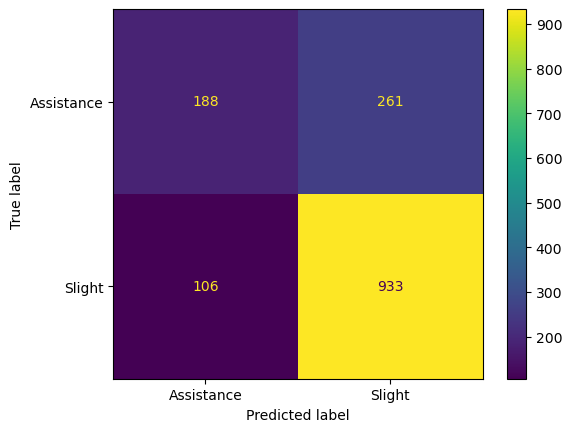

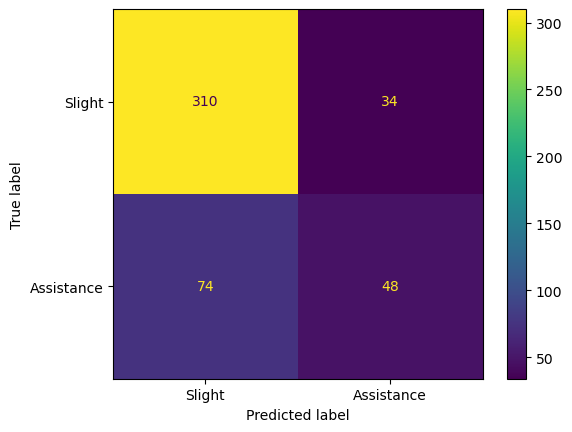

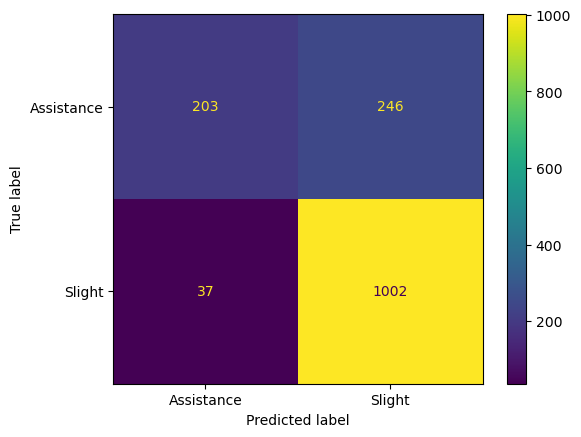

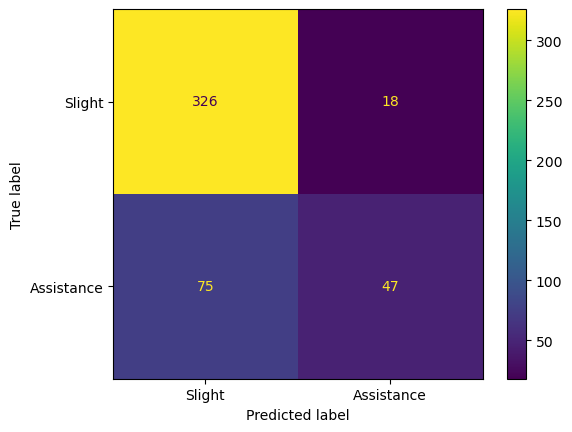

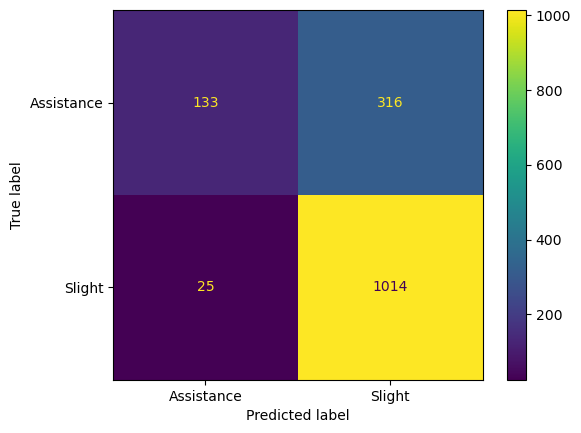

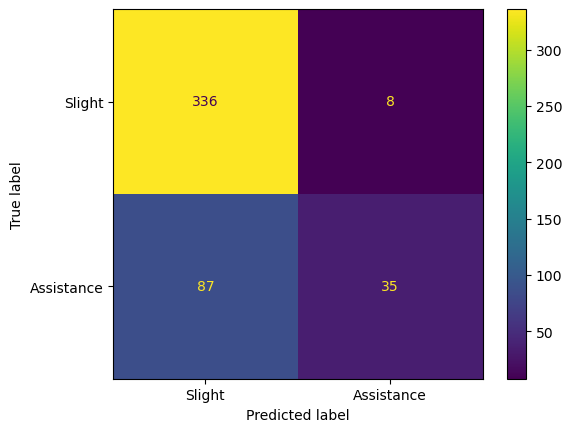

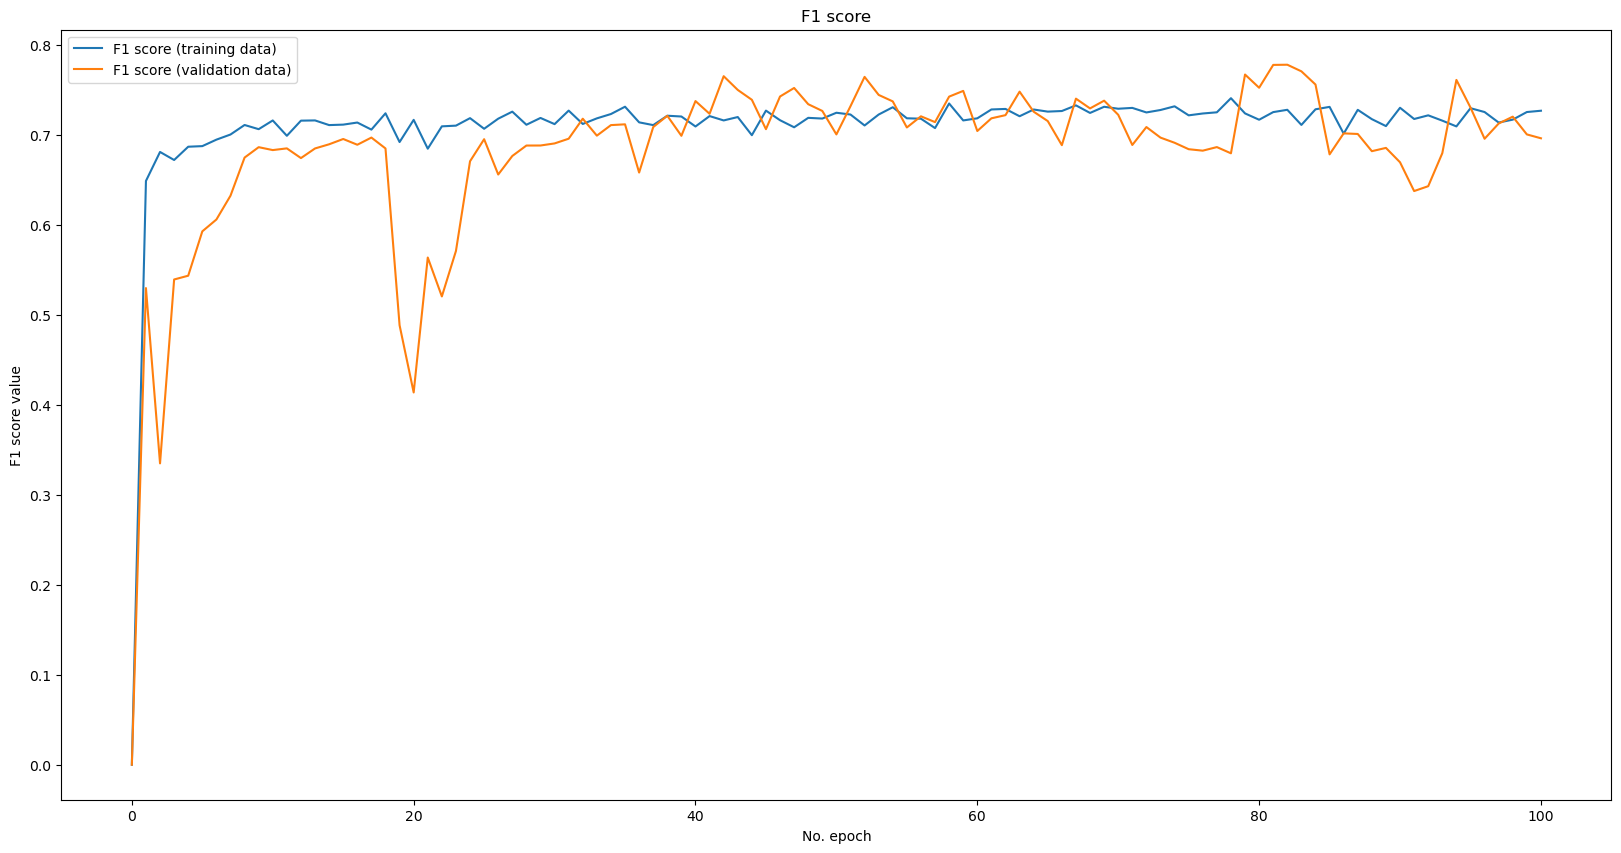

12/12 [==============================] - 0s 1ms/step
              precision  recall  f1-score   support
Assistance        0.886   0.742     0.808  1039.000
Slight            0.566   0.780     0.656   449.000
accuracy          0.753   0.753     0.753     0.753
macro avg         0.726   0.761     0.732  1488.000
weighted avg      0.790   0.753     0.762  1488.000
              precision  recall  f1-score  support
Slight            0.863   0.735     0.794  344.000
Assistance        0.474   0.672     0.556  122.000
accuracy          0.719   0.719     0.719    0.719
macro avg         0.669   0.704     0.675  466.000
weighted avg      0.762   0.719     0.732  466.000


In [149]:
if city and not laptop and cnn1d:

    print("[INFO] evaluating network...")

    Y_predicted = convolution_1d.predict(x = array_test_images, batch_size = 128).argmax(axis = 1)

    if train_nn:
        F1_SCORE_PATH = f"{F1_SCORES_PATH}{MODEL_NAME}/"
        F1_SCORE_NAME = f"{city_name}_{MODEL_NAME}_f1_score_{MODEL_TIMESTAMP}.svg"

        plot_f1_score_history(f1_score_path = F1_SCORE_PATH,
                              f1_score_name = F1_SCORE_NAME,
                              history = history)

        Y_train_predicted = convolution_1d.predict(x = array_train_images, batch_size = 128).argmax(axis = 1)

        save_classification_report_and_confussion_matrix(model_name = MODEL_NAME,
                                                         model_timestamp = MODEL_TIMESTAMP,
                                                         y_true = Y_train,
                                                         y_predicted = Y_train_predicted,
                                                         data = 'train')

    save_classification_report_and_confussion_matrix(model_name = MODEL_NAME,
                                                     model_timestamp = MODEL_TIMESTAMP,
                                                     y_true = Y_test,
                                                     y_predicted = Y_predicted,
                                                     data = 'test')

### Convolution 2D

In [150]:
if city:

    MODEL_NAME = MODELS_NAME[2]

    MODEL_PATH = f"{MODELS_PATH}{MODEL_NAME}/"
    MODEL_FILE_NAME = 'madrid_convolution_2d_2022-05-19-06:33:55.h5'

#### Entrenamiento

In [148]:
if city and train_nn:
    
    fm_one, fm_two, fm_three, fm_four = (256, 512, 512, 256)

    dense  = 32

    learnRate = 0.00001

    batchSize = 128

    start = time.time()

    tasp_cnn = get_tasp_cnn(fm_one = fm_one,
                            fm_two = fm_two,
                            fm_three = fm_three,
                            fm_four = fm_four,
                            dense = dense,
                            dropout = 0.2,
                            learnRate = learnRate)

    history = tasp_cnn.fit(array_train_images, Y_train_onehot,
                           # class_weight = pesos,
                           batch_size = batchSize,
                           epochs = 100,
                           shuffle = True,
                           validation_data = (array_test_images, Y_test_onehot))

    end = time.time()

    ellapsed_time = round(end - start, 2)

    model_time = pd.DataFrame({'city': [city_name],
                               'model': [MODEL_NAME],
                               'time': [ellapsed_time]})
    times = times.append(model_time)    

    history

    

Epoch 1/100
12/12 [==============================] - 1s 27ms/step - loss: 0.7389 - f1_score: 0.6787 - val_loss: 0.6768 - val_f1_score: 0.6667
Epoch 2/100
12/12 [==============================] - 0s 11ms/step - loss: 0.5580 - f1_score: 0.7388 - val_loss: 0.6607 - val_f1_score: 0.6667
Epoch 3/100
12/12 [==============================] - 0s 13ms/step - loss: 0.5006 - f1_score: 0.7604 - val_loss: 0.6456 - val_f1_score: 0.6667
Epoch 4/100
12/12 [==============================] - 0s 11ms/step - loss: 0.4584 - f1_score: 0.7670 - val_loss: 0.6332 - val_f1_score: 0.6667
Epoch 5/100
12/12 [==============================] - 0s 10ms/step - loss: 0.4307 - f1_score: 0.7746 - val_loss: 0.6274 - val_f1_score: 0.6667
Epoch 6/100
12/12 [==============================] - 0s 10ms/step - loss: 0.3994 - f1_score: 0.7909 - val_loss: 0.6152 - val_f1_score: 0.6667
Epoch 7/100
 9/12 [=====================>........] - ETA: 0s - loss: 0.3803 - f1_score: 0.8011

KeyboardInterrupt: 

In [155]:
from tensorflow.keras.wrappers.scikit_learn import KerasClassifier
from sklearn.model_selection import RandomizedSearchCV


model_time = pd.DataFrame({'city': [city_name],
                           'model': [MODEL_NAME],
                           'time': 0})
times = times.append(model_time)
# wrap our model into a scikit-learn compatible classifier
print("[INFO] initializing model...")
model = KerasClassifier(build_fn=get_tasp_cnn, verbose=10)

# define a grid of the hyperparameter search space

# fm_one = fm_two = fm_three = fm_four = fm_five = fm_six = [32, 64, 128, 256, 512]
fm_one = fm_two = fm_three = fm_four = [32, 64, 128, 256, 512, 1024]

dense  = [8, 16, 32, 64, 128, 256]

learnRate = [0.1, 1e-2, 1e-3, 1e-4]

batchSize = [128]

epochs = [50]

num_classes = [2]

# create a dictionary from the hyperparameter grid
grid = dict(
	fm_one = fm_one,
    fm_two = fm_two,
    fm_three = fm_three,
    fm_four = fm_four,
    # fm_five = fm_five,
    # fm_six = fm_six,
    dense = dense,
    num_classes=num_classes,
	learnRate=learnRate,
	batch_size=batchSize,
	epochs=epochs
)

# initialize a random search with a 3-fold cross-validation and then
# start the hyperparameter search process
print("[INFO] performing random search...")
searcher = RandomizedSearchCV(estimator = model,
                              n_iter = 150,
                              cv = 3,
                              param_distributions = grid,
                              scoring = 'f1_micro',
                              verbose = 0)

searchResults = searcher.fit(array_train_images, Y_train)

# summarize grid search information
bestScore = searchResults.best_score_
bestParams = searchResults.best_params_

print("[INFO] best score is {:.2f} using {}".format(bestScore,	bestParams))

print("[INFO] evaluating the best model...")
tasp_cnn = bestModel = searchResults.best_estimator_
# accuracy = bestModel.score(array_test_images, Y_test)
# print("accuracy: {:.2f}%".format(accuracy * 100))

text_file = open(f"./madrid-CNN2D-{MODEL_TIMESTAMP}.txt", "w")
n = text_file.write(str(searchResults.cv_results_))
text_file.close()

[INFO] initializing model...
[INFO] performing random search...
Epoch 1/50


/tmp/ipykernel_13393/398232910.py:8: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  times = times.append(model_time)
/tmp/ipykernel_13393/398232910.py:11: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  model = KerasClassifier(build_fn=get_tasp_cnn, verbose=10)


Epoch 1/50
Epoch 1/50
Epoch 1/50
Epoch 1/50
Epoch 1/50
Epoch 1/50
Epoch 1/50
Epoch 1/50
Epoch 1/50
Epoch 1/50
Epoch 1/50
Epoch 1/50
Epoch 1/50
Epoch 1/50
Epoch 1/50
Epoch 1/50
Epoch 1/50
Epoch 1/50
Epoch 1/50
Epoch 1/50
Epoch 1/50
Epoch 1/50
Epoch 1/50
Epoch 1/50
Epoch 1/50
Epoch 1/50
Epoch 1/50
Epoch 1/50
Epoch 1/50
Epoch 1/50
Epoch 1/50
Epoch 1/50
Epoch 1/50
Epoch 1/50
Epoch 1/50
Epoch 1/50
Epoch 1/50
Epoch 1/50
Epoch 1/50
Epoch 1/50
Epoch 1/50
Epoch 1/50
Epoch 1/50
Epoch 1/50
Epoch 1/50
Epoch 1/50
Epoch 1/50
Epoch 1/50
Epoch 1/50
Epoch 1/50
Epoch 1/50
Epoch 1/50
Epoch 1/50
Epoch 1/50
Epoch 1/50
Epoch 1/50
Epoch 1/50
Epoch 1/50
Epoch 1/50
Epoch 1/50
Epoch 1/50
Epoch 1/50
Epoch 1/50
Epoch 1/50
Epoch 1/50
Epoch 1/50
Epoch 1/50
Epoch 1/50
Epoch 1/50
Epoch 1/50
Epoch 1/50
Epoch 1/50
Epoch 1/50
Epoch 1/50
Epoch 1/50
Epoch 1/50
Epoch 1/50
Epoch 1/50
Epoch 1/50
Epoch 1/50
Epoch 1/50
Epoch 1/50
Epoch 1/50
Epoch 1/50
Epoch 1/50
Epoch 1/50
Epoch 1/50
Epoch 1/50
Epoch 1/50
Epoch 1/50
Epoch 1/50

/home/luis/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:372: FitFailedWarning: 
450 fits failed out of a total of 450.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
450 fits failed with the following error:
Traceback (most recent call last):
  File "/home/luis/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py", line 680, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/home/luis/anaconda3/lib/python3.9/site-packages/keras/wrappers/scikit_learn.py", line 248, in fit
    return super().fit(x, y, **kwargs)
  File "/home/luis/anaconda3/lib/python3.9/site-packages/keras/wrappers/scikit_learn.py", line 175, in fit
    history = self.model.fit(x, y, **fit_a

ValueError: in user code:

    File "/home/luis/anaconda3/lib/python3.9/site-packages/keras/engine/training.py", line 1160, in train_function  *
        return step_function(self, iterator)
    File "/home/luis/anaconda3/lib/python3.9/site-packages/keras/engine/training.py", line 1146, in step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "/home/luis/anaconda3/lib/python3.9/site-packages/keras/engine/training.py", line 1135, in run_step  **
        outputs = model.train_step(data)
    File "/home/luis/anaconda3/lib/python3.9/site-packages/keras/engine/training.py", line 994, in train_step
        loss = self.compute_loss(x, y, y_pred, sample_weight)
    File "/home/luis/anaconda3/lib/python3.9/site-packages/keras/engine/training.py", line 1052, in compute_loss
        return self.compiled_loss(
    File "/home/luis/anaconda3/lib/python3.9/site-packages/keras/engine/compile_utils.py", line 265, in __call__
        loss_value = loss_obj(y_t, y_p, sample_weight=sw)
    File "/home/luis/anaconda3/lib/python3.9/site-packages/keras/losses.py", line 152, in __call__
        losses = call_fn(y_true, y_pred)
    File "/home/luis/anaconda3/lib/python3.9/site-packages/keras/losses.py", line 272, in call  **
        return ag_fn(y_true, y_pred, **self._fn_kwargs)
    File "/home/luis/anaconda3/lib/python3.9/site-packages/keras/losses.py", line 2162, in binary_crossentropy
        backend.binary_crossentropy(y_true, y_pred, from_logits=from_logits),
    File "/home/luis/anaconda3/lib/python3.9/site-packages/keras/backend.py", line 5677, in binary_crossentropy
        return tf.nn.sigmoid_cross_entropy_with_logits(

    ValueError: `logits` and `labels` must have the same shape, received ((None, 2) vs (None, 1)).


#### Escritura del modelo

In [152]:
tasp_cnn = bestModel = searchResults.best_estimator_


In [154]:
if city and train_nn:
    MODEL_PATH = f"{MODELS_PATH}{MODEL_NAME}/"
    MODEL_FILE_NAME = f"{city_name}_{MODEL_NAME}_{MODEL_TIMESTAMP}_1.h5"

    tasp_cnn.save(MODEL_PATH + MODEL_FILE_NAME)

#### Carga de modelo pre-entrenado

In [155]:
if city and not train_nn and not laptop:
    # MODEL_FILE_NAME = f"{city_name}_{MODEL_NAME}_{timestamp_load}.joblib"
    MODEL_FILE_NAME = 'madrid_convolution_2d_2022-05-18-19:50:16.h5'

    tasp_cnn = tf.keras.models.load_model(MODEL_PATH + MODEL_FILE_NAME)

In [156]:
# ## Exportar los kernels

# n_samples = 3
# layers = [0, 2, 4, 6]

# for layer_number in layers:
#     filters, biases = tasp_cnn.layers[layer_number].get_weights()
    
#     layer_name = layer_number//2 + 1

#     for i in range(n_samples):
#         # X,Y, channel, filter_number
#         current_filter = filters[:,:,0, i]

#         plt.figure(figsize=(3, 3))
#         plt.grid(b = None)
#         plt.imshow(current_filter, cmap='gray')

#         # plt.savefig(f"filters/{city_name}_filter_layer_{layer_name}_{i}.svg", transparent=True)
#         plt.show()

In [157]:
# # import tf.keras.mo.Model
# tasp_cnn_feature_maps = tf.keras.models.Model(inputs = tasp_cnn.inputs, outputs=tasp_cnn.layers[0].output)

# tasp_cnn_feature_maps.predict(array_train_images[:3]).shape

In [158]:
# feature_maps = tasp_cnn.predict(array_train_images)
# # plot all 64 maps in an 8x8 squares
# square = 5
# ix = 1
# for _ in range(square):
#     for _ in range(square):
#         # specify subplot and turn of axis

#         # plot filter channel in grayscale
#         plt.imshow(tasp_cnn_feature_maps[ix-1,:,:,:], cmap='gray')
#         ix += 1
# # show the figure
# plt.show()

#### Resultados

In [154]:
if city and not laptop:

    print("[INFO] evaluating network...")

    Y_predicted = tasp_cnn.predict(x = array_test_images, batch_size = 128).argmax(axis = 1)
    rep = {'Slight': 0, 'Assistance': 1}
    Y_train.replace(rep, inplace=True)
    Y_test.replace(rep, inplace=True)

    if train_nn:
        F1_SCORE_PATH = f"{F1_SCORES_PATH}{MODEL_NAME}/"
        F1_SCORE_NAME = f"{city_name}_{MODEL_NAME}_f1_score_{MODEL_TIMESTAMP}_1.svg"

        # plot_f1_score_history(f1_score_path = F1_SCORE_PATH,
        #                       f1_score_name = F1_SCORE_NAME,
        #                       history = history)

        Y_train_predicted = tasp_cnn.predict(x = array_train_images, batch_size = 128).argmax(axis = 1)

        save_classification_report_and_confussion_matrix(model_name = MODEL_NAME,
                                                         model_timestamp = MODEL_TIMESTAMP,
                                                         y_true = Y_train,
                                                         y_predicted = Y_train_predicted,
                                                         data = 'train')

    save_classification_report_and_confussion_matrix(model_name = MODEL_NAME,
                                                     model_timestamp = MODEL_TIMESTAMP,
                                                     y_true = Y_test,
                                                     y_predicted = Y_predicted,
                                                     data = 'test')


[INFO] evaluating network...
12/12 [==============================] - 0s 1ms/step
              precision  recall  f1-score   support
Assistance        0.698   1.000     0.822  1039.000
Slight            0.000   0.000     0.000   449.000
accuracy          0.698   0.698     0.698     0.698
macro avg         0.349   0.500     0.411  1488.000
weighted avg      0.488   0.698     0.574  1488.000
              precision  recall  f1-score  support
Slight            0.738   1.000     0.849  344.000
Assistance        0.000   0.000     0.000  122.000
accuracy          0.738   0.738     0.738    0.738
macro avg         0.369   0.500     0.425  466.000
weighted avg      0.545   0.738     0.627  466.000


/home/luis/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/luis/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/luis/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/luis/anaconda3/lib/python3.9/si

In [160]:
history.history

{'loss': [0.6916465163230896,
  0.5578365921974182,
  0.5082603096961975,
  0.47432658076286316,
  0.4442392587661743,
  0.4205334484577179,
  0.39522039890289307,
  0.3767796456813812,
  0.3585660755634308,
  0.3427010476589203,
  0.33212804794311523,
  0.3173167407512665,
  0.305358350276947,
  0.29325535893440247,
  0.28808820247650146,
  0.2760572135448456,
  0.27347469329833984,
  0.2668977677822113,
  0.2675858438014984,
  0.259274959564209,
  0.2560826241970062,
  0.25337016582489014,
  0.24798469245433807,
  0.2502869963645935,
  0.2429039031267166,
  0.2411416620016098,
  0.24017299711704254,
  0.234971284866333,
  0.2323448359966278,
  0.23500579595565796,
  0.23712830245494843,
  0.22816897928714752,
  0.2288634181022644,
  0.22369222342967987,
  0.22227594256401062,
  0.22139032185077667,
  0.22314698994159698,
  0.23006293177604675,
  0.22154733538627625,
  0.21928851306438446,
  0.2165457159280777,
  0.21903786063194275,
  0.2120175063610077,
  0.2171710878610611,
  0.213

## AutoML

In [161]:
MODEL_NAME = MODELS_NAME[3]

In [162]:
# tasp_cnn.save(root_path + 'madrid_model_XGBOOST_predicted.h5')

In [163]:
# import autokeras as ak

# # clf = ak.ImageClassifier(num_classes = 3,
# #                          loss='categorical_crossentropy',
# #                          metrics = [tfa.metrics.F1Score(num_classes = num_classes, average='micro', threshold = 0.1)],
# #                          overwrite = True,
# #                          tuner= 'bayesian',
# #                          max_trials = 20,
# #                          max_model_size = 3000000
# #                         )
# clf = ak.StructuredDataClassifier(num_classes = 3,
#                              loss='categorical_crossentropy',
#                              metrics = [tfa.metrics.F1Score(num_classes = num_classes, average='micro', threshold = 0.1)],
#                              overwrite = True,
#                              tuner= 'bayesian',
#                              max_trials = 20
#                         )

# clf.fit(array_train_images,
#         np.asarray(Y_train),
#         epochs = 100,
#         batch_size = 128,
#         validation_data = (array_test_images, np.asarray(Y_test)))

# best_auto_model = clf.export_model()
# print(best_auto_model.summary())

### Escritura del modelo

In [164]:
# MODEL_PATH = f"{MODELS_PATH}{MODEL_NAME}/"
# MODEL_FILE_NAME = f"{city_name}_{MODEL_NAME}_{MODEL_TIMESTAMP}.h5"

# best_auto_model.save(MODEL_PATH + MODEL_FILE_NAME)

### Resultados

In [165]:
# Y_predicted = best_auto_model.predict(x = array_test_images, batch_size = 128).argmax(axis = 1)

# F1_SCORE_PATH = f"{F1_SCORES_PATH}{MODEL_NAME}/"
# F1_SCORE_NAME = f"{city_name}_{MODEL_NAME}_f1_score_{MODEL_TIMESTAMP}.svg"

# # plot_f1_score(f1_score_path = F1_SCORE_PATH,
# #               f1_score_name = F1_SCORE_NAME,
# #               history = history)

# print("[INFO] evaluating network...")

# REPORT_PATH = f"{REPORTS_PATH}{MODEL_NAME}/"
# REPORT_NAME  = f"{city_name}_{MODEL_NAME}_report_{MODEL_TIMESTAMP}.csv"

# plot_classification_report(path = REPORT_PATH,
#                            file_name = REPORT_NAME,
#                            y_true = Y_test,
#                            y_predicted = Y_predicted)


# CONFUSION_MATRIX_PATH = f"{CONFUSIONS_MATRIX_PATH}{MODEL_NAME}/"
# CONFUSION_MATRIX_NAME  = f"{city_name}_{MODEL_NAME}_confusion_matrix_{MODEL_TIMESTAMP}.svg"

# plot_confusion_matrix(path = CONFUSION_MATRIX_PATH,
#                       file_name = CONFUSION_MATRIX_NAME,
#                       y_true = Y_test,
#                       y_predicted = Y_predicted)

## AutoML

In [166]:
MODEL_NAME = MODELS_NAME[3]

# Data Summary

## Models times plot

### Sort

In [167]:
times = times.sort_values('time')

### Save csv

In [168]:
SAVE_PATH = f"{REPORTS_TIMES_PATH}{MODEL_TIMESTAMP}.csv"
times.to_csv(SAVE_PATH, index= True)

### Save fig

In [169]:
# LOAD_PATH = f"{REPORTS_TIMES_PATH}2022-05-23-15:28:04.csv"
# times = pd.read_csv(LOAD_PATH)

# ax = sns.barplot(x = 'time',
#                  y = 'model',
#                  palette='deep',
#                  data = times).set(title = f"Models Fitting Time (s)")
# plt.xlabel("Time (s)")

# SAVE_PATH = f"{REPORTS_TIMES_PATH}{MODEL_TIMESTAMP}.png"
# plt.savefig(SAVE_PATH)

## Models metrics file

In [170]:
from os.path import exists

reports_summary = pd.DataFrame()

cities = []
# MODEL_TIMESTAMP = '2022-08-02-10:10:19'

# cities.append('leeds')  if leeds else None
cities.append('madrid') if madrid else None
# cities.append('UK') if UK else None

models_renaming = {'knn': 'KNN',
                   'convolution_1d': '1D-convolution',
                   'convolution_2d': '2D-convolution',
                   'nb': 'NB',
                   'svc': 'SVC'}
                   # 'auto_ml': 'AutoML'}

splits = ['train', 'test']
sorted_by_time_models_name = times.model

for split in splits:
    reports_summary = pd.DataFrame()

    for model_name in sorted_by_time_models_name:

        REPORT_PATH = f"{REPORTS_PATH}{model_name}/{split}/"

        for city_name in cities:

            REPORT_NAME  = f"{city_name}_{model_name}_report_{MODEL_TIMESTAMP}.csv"

            if exists(REPORT_PATH + REPORT_NAME):
                print(f"Found: {model_name} for {split}")
                report = pd.read_csv(REPORT_PATH + REPORT_NAME, index_col=[0])
                report.insert(0, 'split', split)
                report.insert(1, 'city', city_name)
                report.insert(2, 'model', models_renaming[model_name])

                reports_summary = pd.concat([reports_summary, report])

                reports_summary = reports_summary.sort_values(['city', 'model'], ascending = [True, True])

    if not reports_summary.empty:
        c_m = reports_summary['city'] + '_' + reports_summary['model']
        reports_summary.insert(0, 'c_m', c_m)

        SAVE_PATH =  f"{REPORTS_SUMMARY_PATH}/{split}/{MODEL_TIMESTAMP}.csv"

        reports_summary.insert(0, 'accident_type', reports_summary.index)
        reports_summary.to_csv(SAVE_PATH, index= True)

Found: nb for train
Found: knn for train
Found: svc for train
Found: convolution_1d for train
Found: convolution_2d for train
Found: nb for test
Found: knn for test
Found: svc for test
Found: convolution_1d for test
Found: convolution_2d for test


## Models scores plot

In [171]:
reports_summary

,accident_type,c_m,split,city,model,precision,recall,f1-score,support
Slight,Slight,madrid_1D-convolution,test,madrid,1D-convolution,0.863,0.735,0.794,344.000
Assistance,Assistance,madrid_1D-convolution,test,madrid,1D-convolution,0.474,0.672,0.556,122.000
accuracy,accuracy,madrid_1D-convolution,test,madrid,1D-convolution,0.719,0.719,0.719,0.719
macro avg,macro avg,madrid_1D-convolution,test,madrid,1D-convolution,0.669,0.704,0.675,466.000
weighted avg,weighted avg,madrid_1D-convolution,test,madrid,1D-convolution,0.762,0.719,0.732,466.000
Slight,Slight,madrid_2D-convolution,test,madrid,2D-convolution,0.832,0.762,0.795,344.000
Assistance,Assistance,madrid_2D-convolution,test,madrid,2D-convolution,0.457,0.566,0.505,122.000
accuracy,accuracy,madrid_2D-convolution,test,madrid,2D-convolution,0.710,0.710,0.710,0.710
macro avg,macro avg,madrid_2D-convolution,test,madrid,2D-convolution,0.644,0.664,0.650,466.000
weighted avg,weighted avg,madrid_2D-convolution,test,madrid,2D-convolution,0.734,0.710,0.719,466.000


In [172]:
import seaborn as sns

MEASURE_TYPES  = ['precision', 'recall', 'f1-score']
# ACCIDENT_TYPES = ['Slight', 'Serious', 'Fatal']

ACCIDENT_TYPES = ['Slight', 'Assistance']


# if leeds:
#     leeds_reports_summary  = reports_summary[reports_summary['city'] == 'leeds']
if madrid:
    madrid_reports_summary = reports_summary[reports_summary['city'] == 'madrid']
# if UK:
#     UK_reports_summary = reports_summary[reports_summary['city'] == 'UK']

# print(leeds_reports_summary.loc[ACCIDENT_TYPES])

for split in splits:
    
    REPORT_PATH = f"{REPORTS_SUMMARY_PATH}{split}/{MODEL_TIMESTAMP}.csv"

    if exists(REPORT_PATH):
        fig, axs = plt.subplots(len(MEASURE_TYPES), len(cities), figsize=(15,20))

        print(f"Found: {REPORT_PATH}")

        report = pd.read_csv(REPORT_PATH, index_col=[0])

#         if leeds:
#             leeds_reports_summary  = report[report['city'] == 'leeds']
        if madrid:
            madrid_reports_summary = report[report['city'] == 'madrid']
        # if UK:
        #     UK_reports_summary = report[report['city'] == 'UK']

        for index, measure_type in enumerate(MEASURE_TYPES):

            # Si son dos ciudades el plot es bidimensional.
            if len(cities) > 1:
                axis_leeds = axs[index, 0]
                axis_madrid = axs[index, 1]
            else:
                axis_leeds = axis_madrid = axis_UK = axs[index]

#             if leeds:
#                 ax = sns.barplot(x = 'accident_type',
#                                  y = measure_type,
#                                  hue = 'model',
#                                  palette = 'deep',
#                                  data = leeds_reports_summary.loc[ACCIDENT_TYPES],
#                                  ax = axis_leeds).set(title = f"{measure_type} Leeds")
                

            if madrid:
                ax = sns.barplot(x = 'accident_type',
                                 y = measure_type,
                                 hue = 'model',
                                 palette = 'deep',
                                 data = madrid_reports_summary.loc[ACCIDENT_TYPES],
                                 ax = axis_madrid).set(title = f"{measure_type} Madrid")
            
#             if UK:
#                 ax = sns.barplot(x = 'accident_type',
#                                  y = measure_type,
#                                  hue = 'model',
#                                  palette = 'deep',
#                                  data = UK_reports_summary.loc[ACCIDENT_TYPES],
#                                  ax = axis_UK).set(title = f"{measure_type} UK")                

        SAVE_PATH = f"{REPORTS_SUMMARY_PATH}{split}/{MODEL_TIMESTAMP}.png"

        fig = fig.get_figure()
        fig.savefig(SAVE_PATH)

Found: Reports/summary/train/2023-04-22-15:25:57.csv
Found: Reports/summary/test/2023-04-22-15:25:57.csv
